<a href="https://colab.research.google.com/github/OlajideFemi/Carbon-Footprint/blob/main/Dissertation_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>ARIMA</h1>

In [1]:
#important imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import json
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense




In [3]:
# 1. Data Preparation
import pandas as pd

url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1166194/2005-21-uk-local-authority-ghg-emissions.xlsx'
data_1_1_cleaned = pd.read_excel(url, sheet_name='1_1', skiprows=4)


In [4]:
data_1_1_cleaned.columns

Index(['Region/Country', 'Second Tier Authority', 'Local Authority',
       'Local Authority Code', 'Calendar Year', 'Industry Electricity',
       'Industry Gas ', 'Large Industrial Installations', 'Industry 'Other'',
       'Industry Total', 'Commercial Electricity', 'Commercial Gas ',
       'Commercial 'Other'', 'Commercial Total', 'Public Sector Electricity',
       'Public Sector Gas ', 'Public Sector 'Other'', 'Public Sector Total',
       'Domestic Electricity', 'Domestic Gas', 'Domestic 'Other'',
       'Domestic Total', 'Road Transport (A roads)',
       'Road Transport (Motorways)', 'Road Transport (Minor roads)',
       'Diesel Railways', 'Transport 'Other'', 'Transport Total',
       'Net Emissions: Forest land', 'Net Emissions: Cropland',
       'Net Emissions: Grassland', 'Net Emissions: Wetlands',
       'Net Emissions: Settlements', 'Net Emissions: Harvested Wood Products',
       'Net Emissions: Indirect N2O', 'LULUCF Net Emissions',
       'Agriculture Electricity', 

In [5]:
data_1_1_cleaned.index

RangeIndex(start=0, stop=7106, step=1)

In [3]:
# Filter the data for the "West Midlands" Region/Country
data_1_1_cleaned = data_1_1_cleaned[data_1_1_cleaned['Region/Country'] == 'West Midlands']
# Filter out rows where "Second Tier Authority" ends with "Total"
data_1_1_cleaned = data_1_1_cleaned[~data_1_1_cleaned['Second Tier Authority'].str.endswith("Total")]

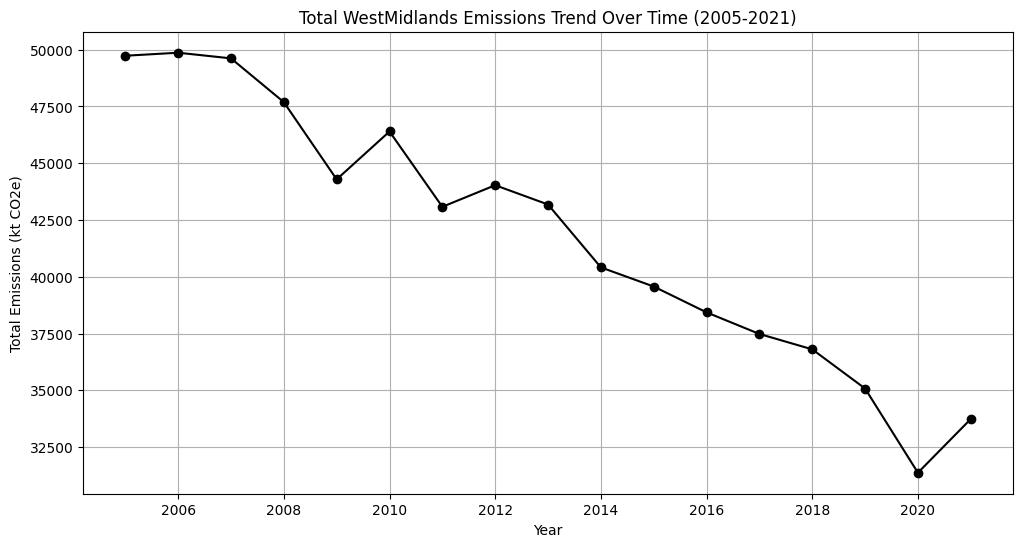

Calendar Year
2005    49732.222417
2006    49865.040184
2007    49616.825647
2008    47689.374420
2009    44287.997799
2010    46396.818960
2011    43080.033683
2012    44031.880064
2013    43181.893928
2014    40413.744458
2015    39570.616279
2016    38433.656517
2017    37482.255734
2018    36805.003905
2019    35080.103036
2020    31372.640144
2021    33736.855308
Name: Grand Total, dtype: float64

In [4]:
import matplotlib.pyplot as plt

# Group by 'Calendar Year' and sum the 'Grand Total' column to get total emissions for each year
yearly_emissions = data_1_1_cleaned.groupby('Calendar Year')['Grand Total'].sum()

yearly_emissions_ = pd.DataFrame(yearly_emissions)

# Plotting the trend over time
plt.figure(figsize=(12, 6))
yearly_emissions.plot(marker='o', linestyle='-', color='black')
plt.title('Total WestMidlands Emissions Trend Over Time (2005-2021)')
plt.xlabel('Year')
plt.ylabel('Total Emissions (kt CO2e)')
plt.grid(True)
plt.show()
yearly_emissions

In [5]:
from statsmodels.tsa.stattools import adfuller

#Augmented Dickey-Fuller test is used to test for the stationarity of a time series
adf_test = adfuller(yearly_emissions_['Grand Total'])
adf_test_output = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

In [6]:
# Adding critical values
for key, value in adf_test[4].items():
    adf_test_output[f'Critical Value ({key})'] = value

In [7]:
adf_test_output

Test Statistic                  1.644176
p-value                         0.997984
#Lags Used                      6.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64

p-value = 0.997984
Given the p-value is larger than 0.05, it suggest non-stationary data hence an attempt to difference the data

because p-value is greater than 0.05 this indicated that its non-stationary hence differencing is required

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Differencing the data to make it stationary
df_diff = yearly_emissions_['Grand Total'].diff().dropna()

adf_test_diff = adfuller(df_diff)
adf_test_diff_output = pd.Series(adf_test_diff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

adf_test_diff_output

Test Statistic                 -5.102136
p-value                         0.000014
#Lags Used                      1.000000
Number of Observations Used    14.000000
dtype: float64

Now p-value 0.000014 is acceptable.
That suggest (d=1)

In [9]:
# Adding critical values
for key, value in adf_test_diff[4].items():
    adf_test_diff_output[f'Critical Value ({key})'] = value

In [10]:
adf_test_diff_output

Test Statistic                 -5.102136
p-value                         0.000014
#Lags Used                      1.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64

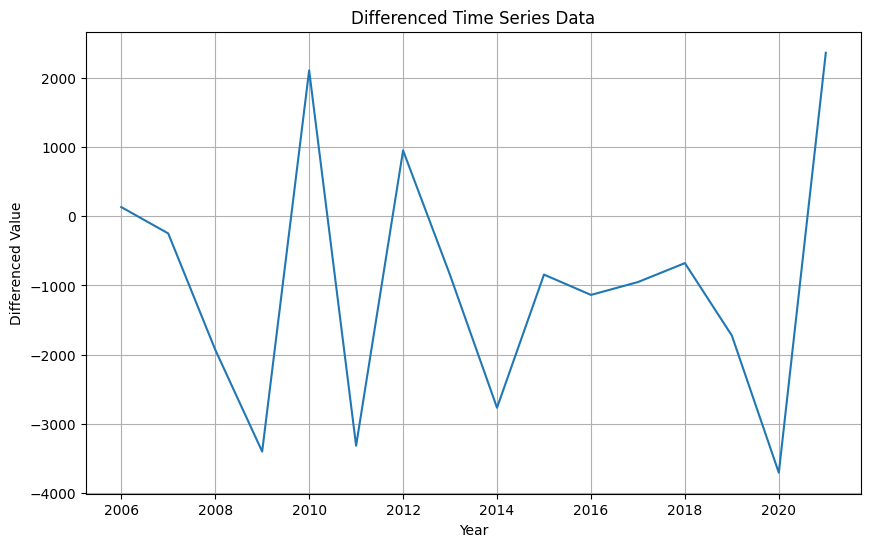

In [11]:
# Plotting the differenced data
plt.figure(figsize=(10, 6))
plt.plot(df_diff)
plt.title('Differenced Time Series Data')
plt.xlabel('Year')
plt.ylabel('Differenced Value')
plt.grid(True)
plt.show()

For the AR and MA(p and q)

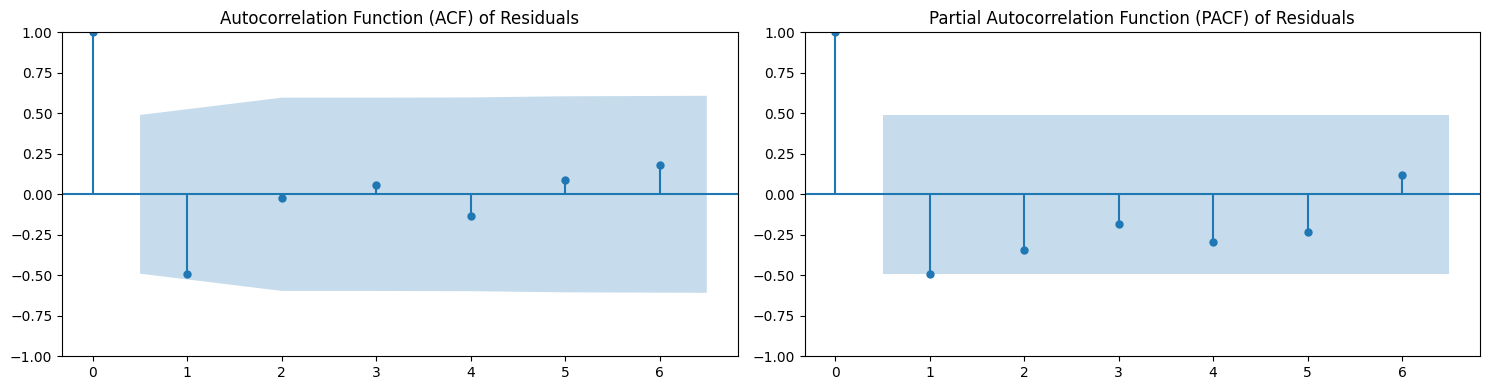

In [12]:
 #ACF and PACF of residuals with fewer lags
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# ACF plot
plot_acf(df_diff, ax=ax[0], lags=6)
ax[0].set_title('Autocorrelation Function (ACF) of Residuals')

# PACF plot
plot_pacf(df_diff, ax=ax[1], lags=6)
ax[1].set_title('Partial Autocorrelation Function (PACF) of Residuals')

plt.tight_layout()
plt.show()


Differencing happen once (d=1), Picking p = 1 and q = 1 from the above plot

In [13]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Filter out the specific warning message
warnings.simplefilter("ignore", category=Warning)


# Fitting the ARIMA model with the determined parameters (p=1, d=1, q=1)
model = ARIMA(yearly_emissions_['Grand Total'], order=(1, 1, 1))
model_fit = model.fit()

# Summarizing the model output
model_summary = model_fit.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Grand Total   No. Observations:                   17
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -142.429
Date:                Sat, 17 Feb 2024   AIC                            290.858
Time:                        14:08:37   BIC                            293.175
Sample:                             0   HQIC                           290.976
                                 - 17                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9270      0.047     19.674      0.000       0.835       1.019
ma.L1         -0.9999      0.460     -2.174      0.030      -1.902      -0.098
sigma2      3.132e+06   1.47e-07   2.14e+13      0.000    3.13e+06    3.13e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.15   Jarque-Bera (JB):                 0.47
Prob(Q):                              0.08   Prob(JB):                         0.79
Heteroskedasticity (H):               1.06   Skew:                             0.15
Prob(H) (two-sided):                  0.95   Kurtosis:                         2.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.19e+28. Standard errors may be unstable.
"""

In [14]:
# Forecasting future values using the ARIMA(1,1,1) model
forecast_periods = 5  # forecasting for next 5 years

# Forecasting future values
forecast = model_fit.forecast(steps=forecast_periods)
print(forecast)


17    33459.620002
18    33202.613189
19    32964.358894
20    32743.488839
21    32538.734582
Name: predicted_mean, dtype: float64


In [15]:
# iterating over the ARIMA model
fitted_values = model_fit.predict(start=1, end=len(yearly_emissions_['Grand Total']))

# Printing the fitted values
print(fitted_values)


1     48344.756406
2     48521.854537
3     48329.290745
4     46521.264575
5     43296.417748
6     45347.749297
7     42204.603475
8     43140.477064
9     42353.687898
10    39733.880016
11    38947.878181
12    37880.404265
13    36988.257415
14    36355.859160
15    34725.826942
16    31209.360027
17    33459.620002
Name: predicted_mean, dtype: float64


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Actual values from 2006 to 2021
actual_values = [49865.040184, 49616.825647, 47689.374420, 44287.997799, 46396.818960,
                 43080.033683, 44031.880064, 43181.893928, 40413.744458, 39570.616279,
                 38433.656517, 37482.255734, 36805.003905, 35080.103036, 31372.640144,
                 33736.855308]

# Fitted values from your model for the same years
fitted_values = [48344.756378, 48521.854516, 48329.290731, 46521.264576, 43296.417769,
                 45347.749311, 42204.603509, 43140.477094, 42353.687935, 39733.880070,
                 38947.878241, 37880.404331, 36988.257487, 36355.859235, 34725.827027,
                 31209.360134]

mse = mean_squared_error(actual_values, fitted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, fitted_values)
r2 = r2_score(actual_values, fitted_values)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)


MSE: 3156817.9134824006
RMSE: 1776.7436262675606
MAE: 1442.5323537499994
R2 Score: 0.8933601637161586


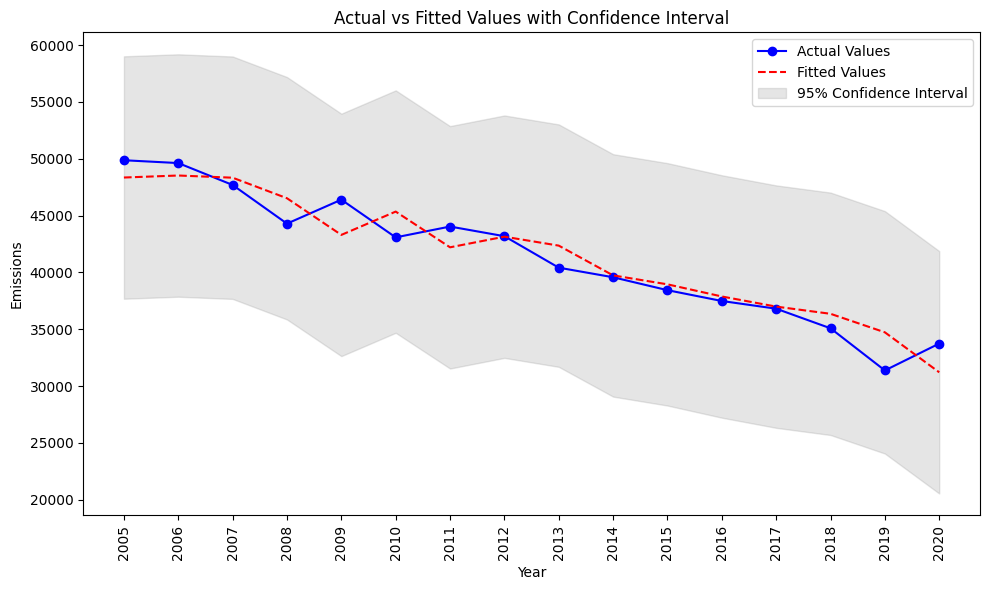

In [17]:
import matplotlib.pyplot as plt

years = range(2005, 2021)

# Actual and fitted values
actual_values = [49865.040184, 49616.825647, 47689.374420, 44287.997799, 46396.818960,
                 43080.033683, 44031.880064, 43181.893928, 40413.744458, 39570.616279,
                 38433.656517, 37482.255734, 36805.003905, 35080.103036, 31372.640144,
                 33736.855308]
fitted_values = [48344.756378, 48521.854516, 48329.290731, 46521.264576, 43296.417769,
                 45347.749311, 42204.603509, 43140.477094, 42353.687935, 39733.880070,
                 38947.878241, 37880.404331, 36988.257487, 36355.859235, 34725.827027,
                 31209.360134]

std_err = [np.std(actual_values)] * len(years)
ci_upper = [fitted + 1.96*err for fitted, err in zip(fitted_values, std_err)]
ci_lower = [fitted - 1.96*err for fitted, err in zip(fitted_values, std_err)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, actual_values, color='blue', marker='o', label='Actual Values')
plt.plot(years, fitted_values, color='red', linestyle='--', label='Fitted Values')
plt.fill_between(years, ci_lower, ci_upper, color='grey', alpha=0.2, label='95% Confidence Interval')
plt.title('Actual vs Fitted Values with Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.xticks(years, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


<h1>Fitting Arima(1,1,1) to Unseen Data</h1>

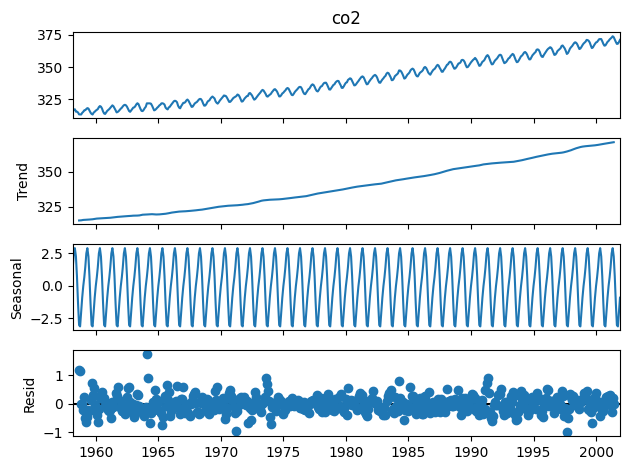

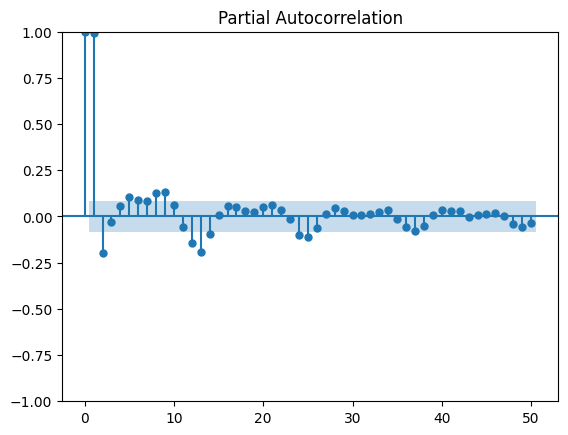

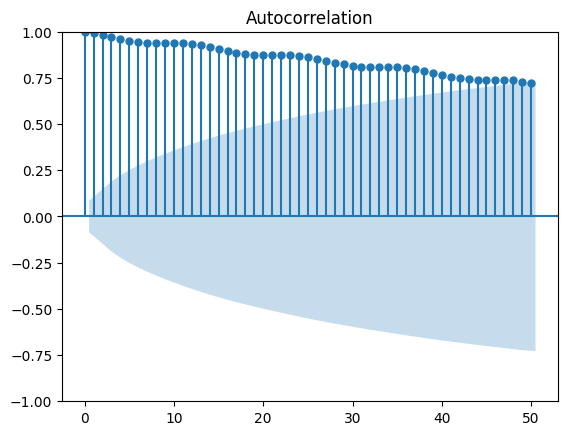

ADF p-value: 0.9989901230798025


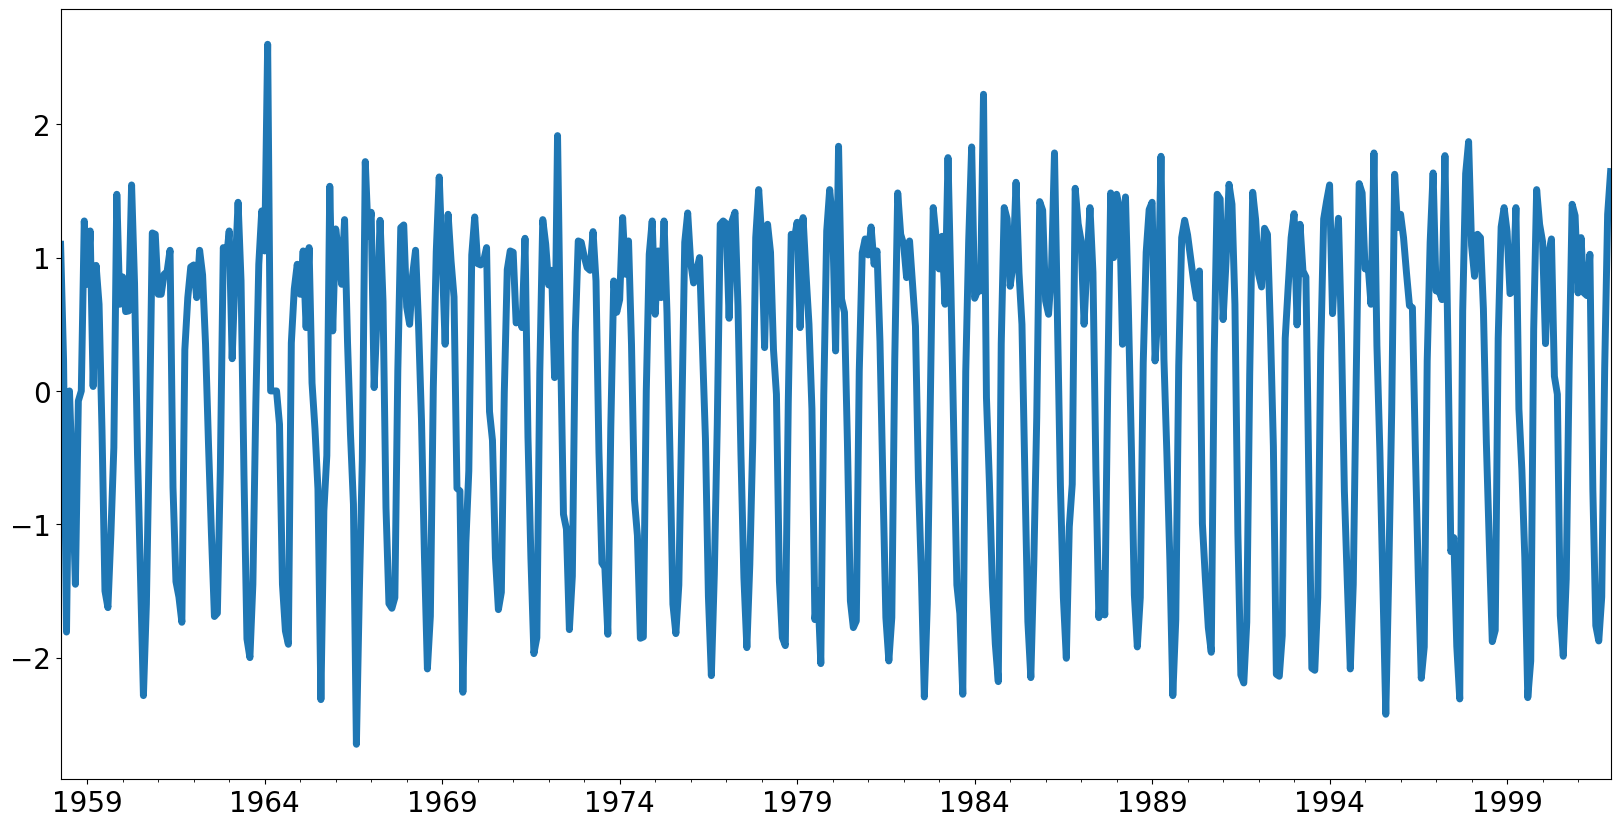

Best SARIMAX(1, 1, 1)x(1, 1, 1, 12)12 - AIC:277.7802190184549
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.441      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.162      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.811      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.632      0.000       0.089       0.106


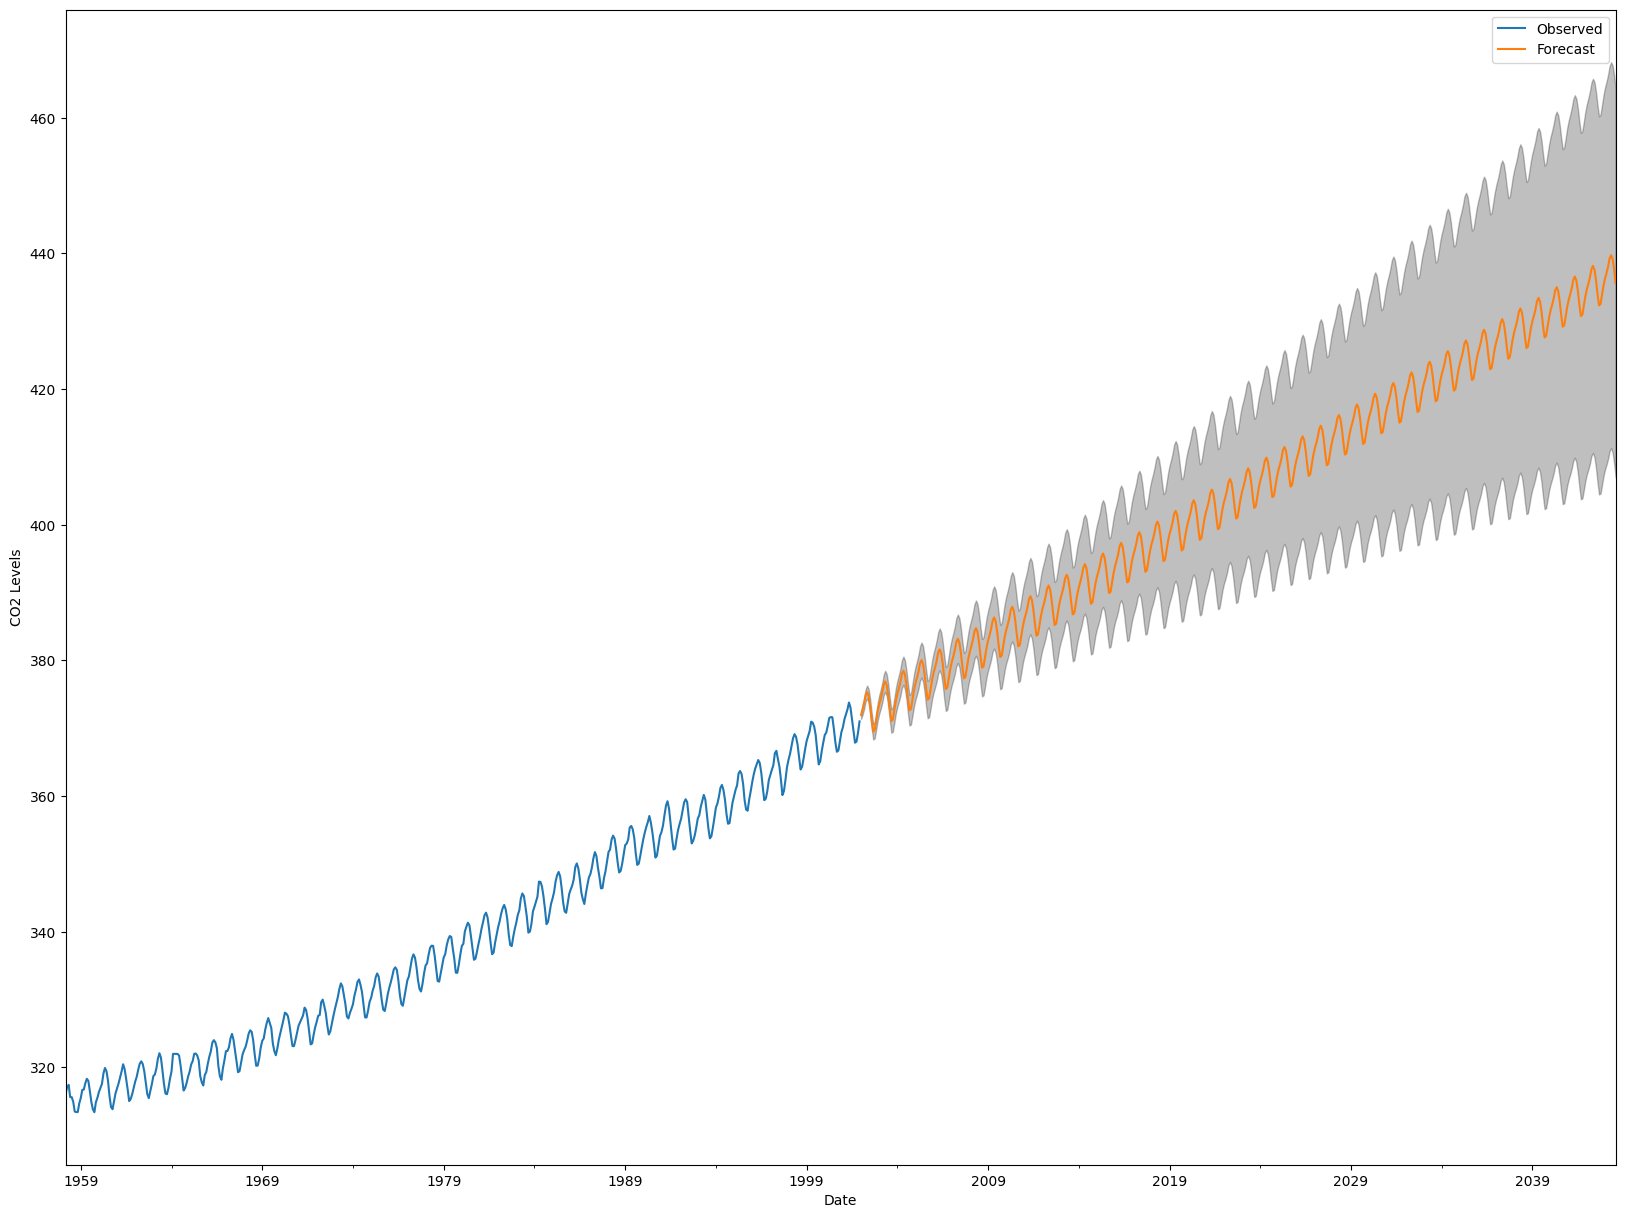

In [18]:
# Import necessary libraries
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Load CO2 dataset from statsmodels
data = sm.datasets.co2.load_pandas()
y = data.data['co2'].resample('MS').mean()  # Monthly resampling
y = y.fillna(y.bfill())  # Backward fill for missing values

# Decompose the time series data
result = seasonal_decompose(y, model='additive')
result.plot()
plt.show()

# Analyze autocorrelation
plot_pacf(y, lags=50)
plot_acf(y, lags=50)
plt.show()

# Conduct Augmented Dickey-Fuller test
adf_test = adfuller(y)
print(f'ADF p-value: {adf_test[1]}')

# Difference the data and plot
y_diff = y.diff().dropna()  # Drop NA values created by differencing
y_diff.plot(figsize=(20, 10), linewidth=5, fontsize=20)
plt.show()

# Grid search for SARIMAX hyperparameters
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

# Find the best SARIMAX parameters based on AIC
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue
print(f'Best SARIMAX{best_pdq}x{best_seasonal_pdq}12 - AIC:{best_aic}')

# Fit the best SARIMAX model
mod = SARIMAX(y,
              order=best_pdq,
              seasonal_order=best_seasonal_pdq,
              enforce_stationarity=False,
              enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

# Forecast and plot
pred_uc = results.get_forecast(steps=500)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='Observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()


<h1>Calibrating Arima Model</h1>

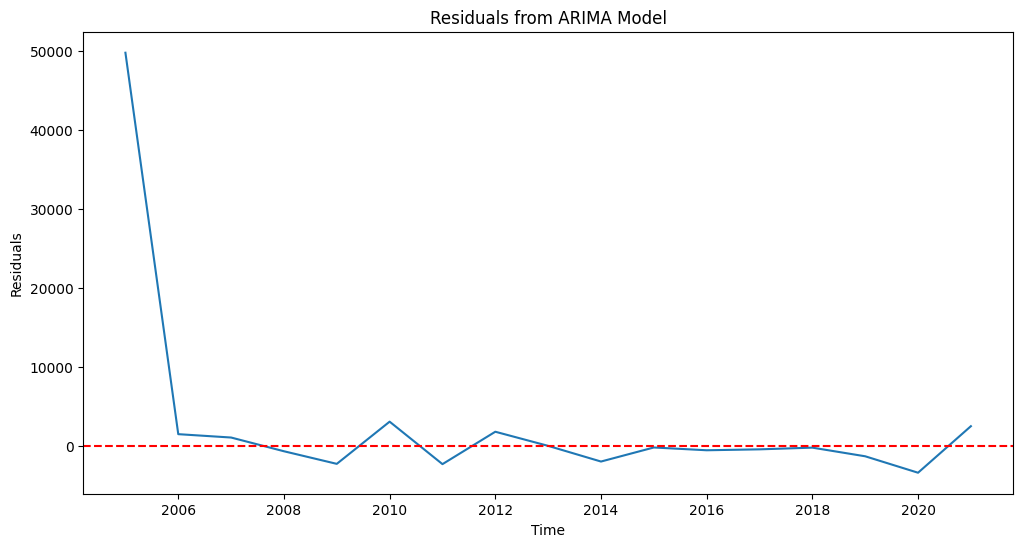

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(model_fit.resid)
plt.title('Residuals from ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


<Figure size 1000x500 with 0 Axes>

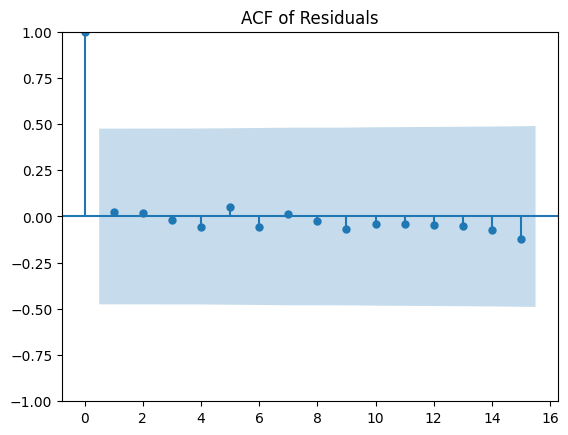

In [20]:
plt.figure(figsize=(10, 5))
plot_acf(model_fit.resid, lags=15)
plt.title('ACF of Residuals')
plt.show()


In [21]:
pip install statsmodels


In [22]:
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_result = acorr_ljungbox(model_fit.resid, lags=[6], return_df=True)
print(ljung_box_result)


    lb_stat  lb_pvalue
6  0.285502   0.999564


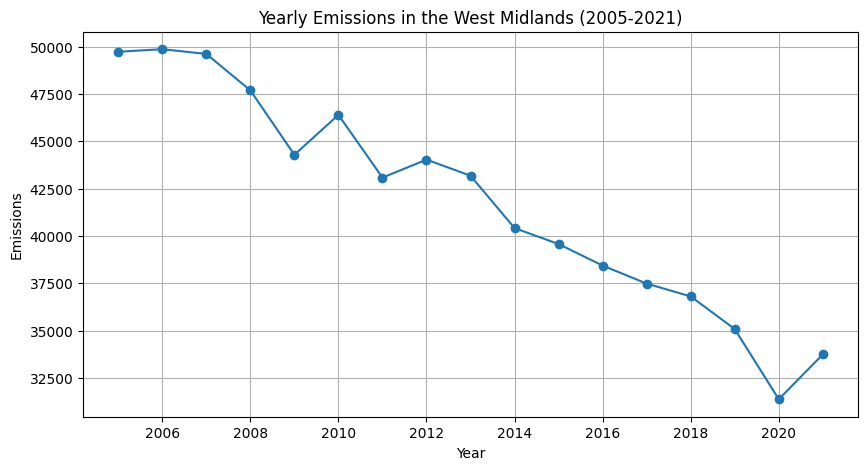

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

yearly_emissions_data = {
    'Year': range(2005, 2022),
    'Emissions': yearly_emissions
}

yearly_emissions_df = pd.DataFrame(yearly_emissions_data)

yearly_emissions_df.set_index('Year', inplace=True)

plt.figure(figsize=(10, 5))
plt.plot(yearly_emissions_df.index, yearly_emissions_df['Emissions'], marker='o')
plt.title('Yearly Emissions in the West Midlands (2005-2021)')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.grid(True)
plt.show()


In [24]:
# Import necessary libraries
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf


if not isinstance(yearly_emissions_, pd.DataFrame):
    yearly_emissions_ = pd.DataFrame(yearly_emissions_)

yearly_emissions_.index = pd.date_range(start='2005', periods=len(yearly_emissions_), freq='Y')

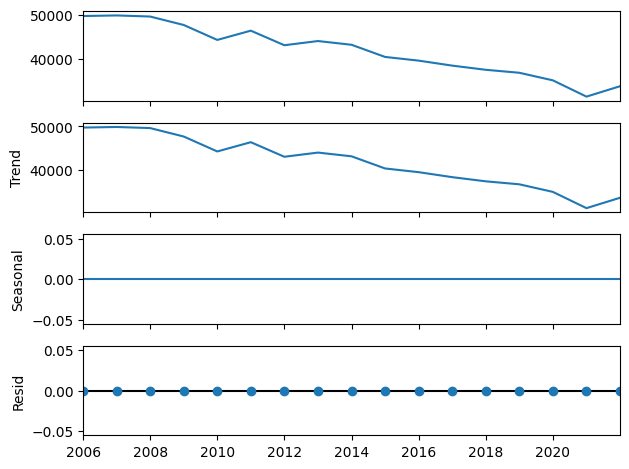

In [25]:

y = yearly_emissions_

# Decompose the time series data
result = seasonal_decompose(y, model='additive')
result.plot()
plt.show()

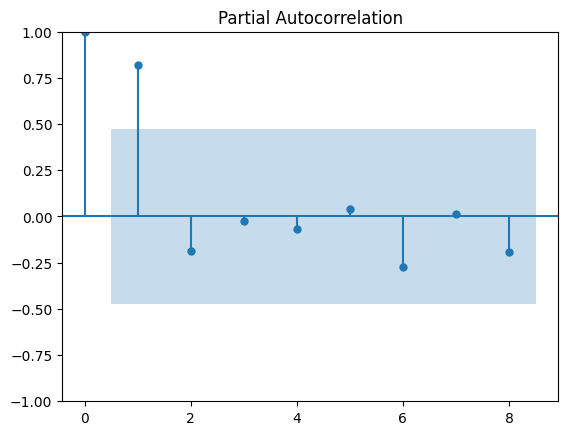

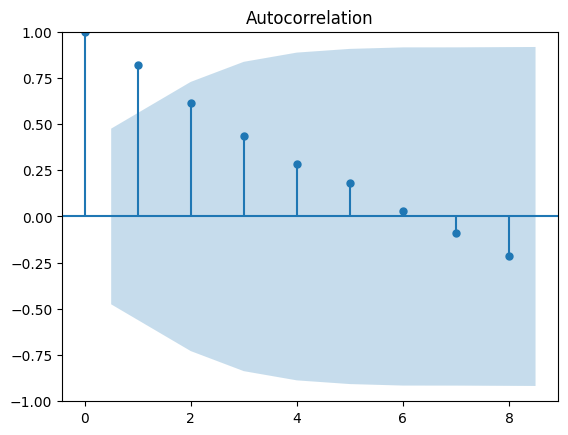

In [26]:
# Analyze autocorrelation
plot_pacf(y, lags=8)
plot_acf(y, lags=8)
plt.show()


In [27]:
# Conduct Augmented Dickey-Fuller test
adf_test = adfuller(y.squeeze())
print(f'ADF p-value: {adf_test[1]}')

ADF p-value: 0.9979842380076093


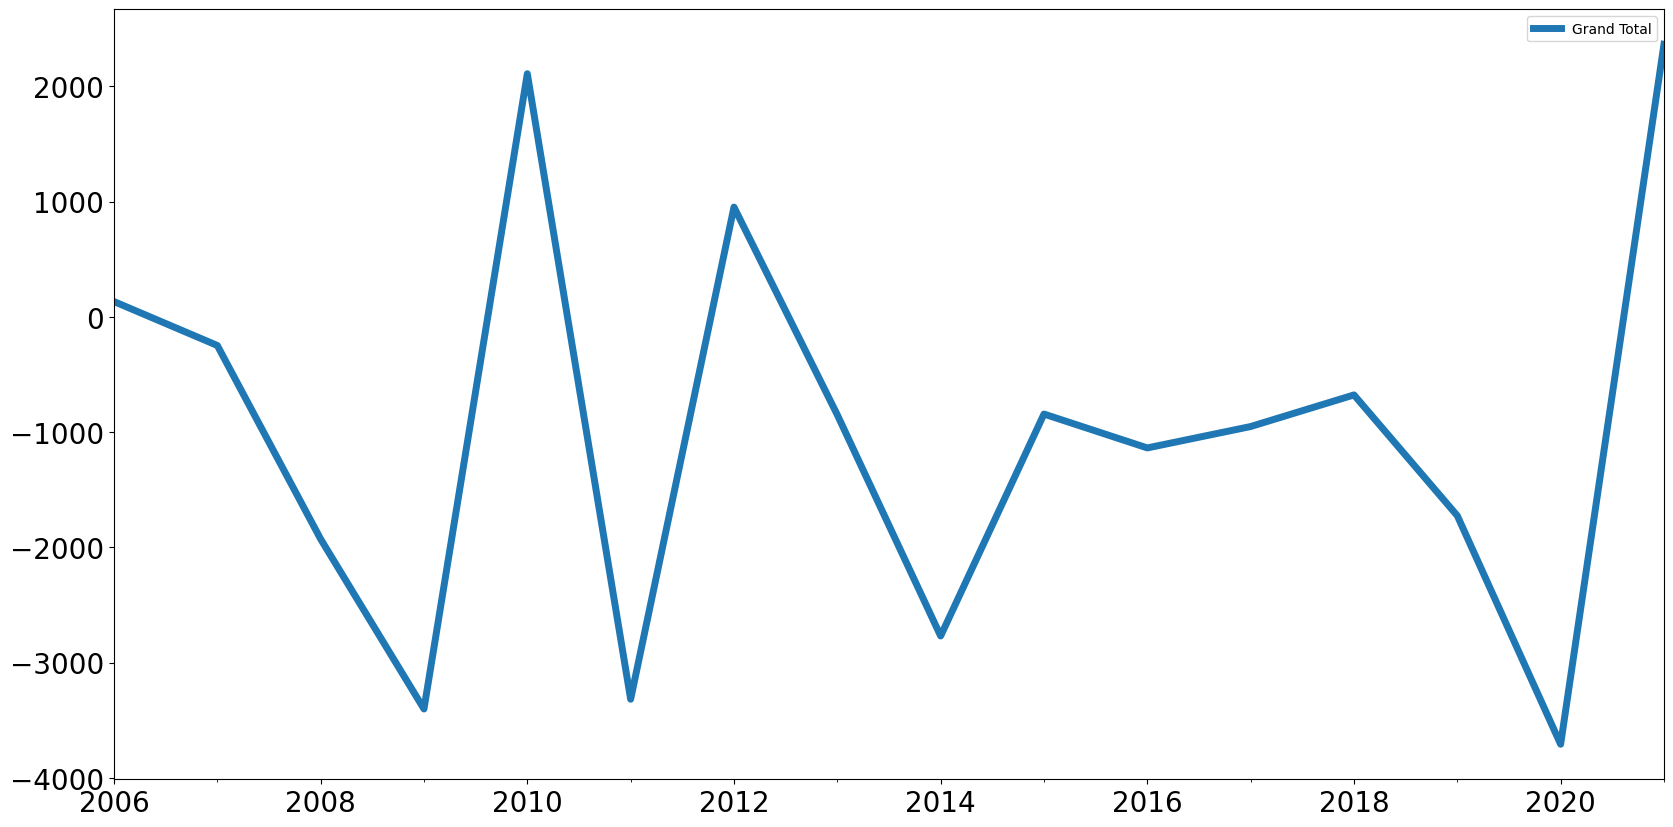

In [28]:
# Difference the data and plot
y_diff = y.diff().dropna()  # Drop NA values created by differencing
y_diff.plot(figsize=(20, 10), linewidth=5, fontsize=20)
plt.show()

In [29]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Find the best SARIMAX parameters based on AIC
best_aic = np.inf
best_pdq = None
for param in pdq:
    try:
        mod = SARIMAX(y,
                      order=param,
                      seasonal_order=(0, 0, 0, 0),  # No seasonal order for annual data
                      enforce_stationarity=False,
                      enforce_invertibility=False)
        results = mod.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
    except:
        continue
print(f'Best ARIMA{best_pdq} - AIC:{best_aic}')

Best ARIMA(1, 2, 2) - AIC:209.3264473420375


In [30]:
# Fit the best SARIMAX model
mod = SARIMAX(y,
              order=best_pdq,
              seasonal_order=(0, 0, 0, 0),  # No seasonal order for annual data
              enforce_stationarity=False,
              enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3830      0.156     -2.457      0.014      -0.689      -0.077
ma.L1         -1.9827      0.263     -7.532      0.000      -2.499      -1.467
ma.L2          1.0273      0.240      4.277      0.000       0.557       1.498
sigma2      8.045e+05   6.32e-07   1.27e+12      0.000    8.05e+05    8.05e+05


Best SARIMAX(1, 2, 2) - AIC:209.3264473420375
Best SARIMAX(1, 2, 2) - BIC:211.26607394118952
Model with best AIC
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3830      0.156     -2.457      0.014      -0.689      -0.077
ma.L1         -1.9827      0.263     -7.532      0.000      -2.499      -1.467
ma.L2          1.0273      0.240      4.277      0.000       0.557       1.498
sigma2      8.045e+05   6.32e-07   1.27e+12      0.000    8.05e+05    8.05e+05
Model with best BIC
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3830      0.156     -2.457      0.014      -0.689      -0.077
ma.L1         -1.9827      0.263     -7.532      0.000      -2.499      -1.467
ma.L2          1.0273      0.240      4.277      0.000       0.557       1.49

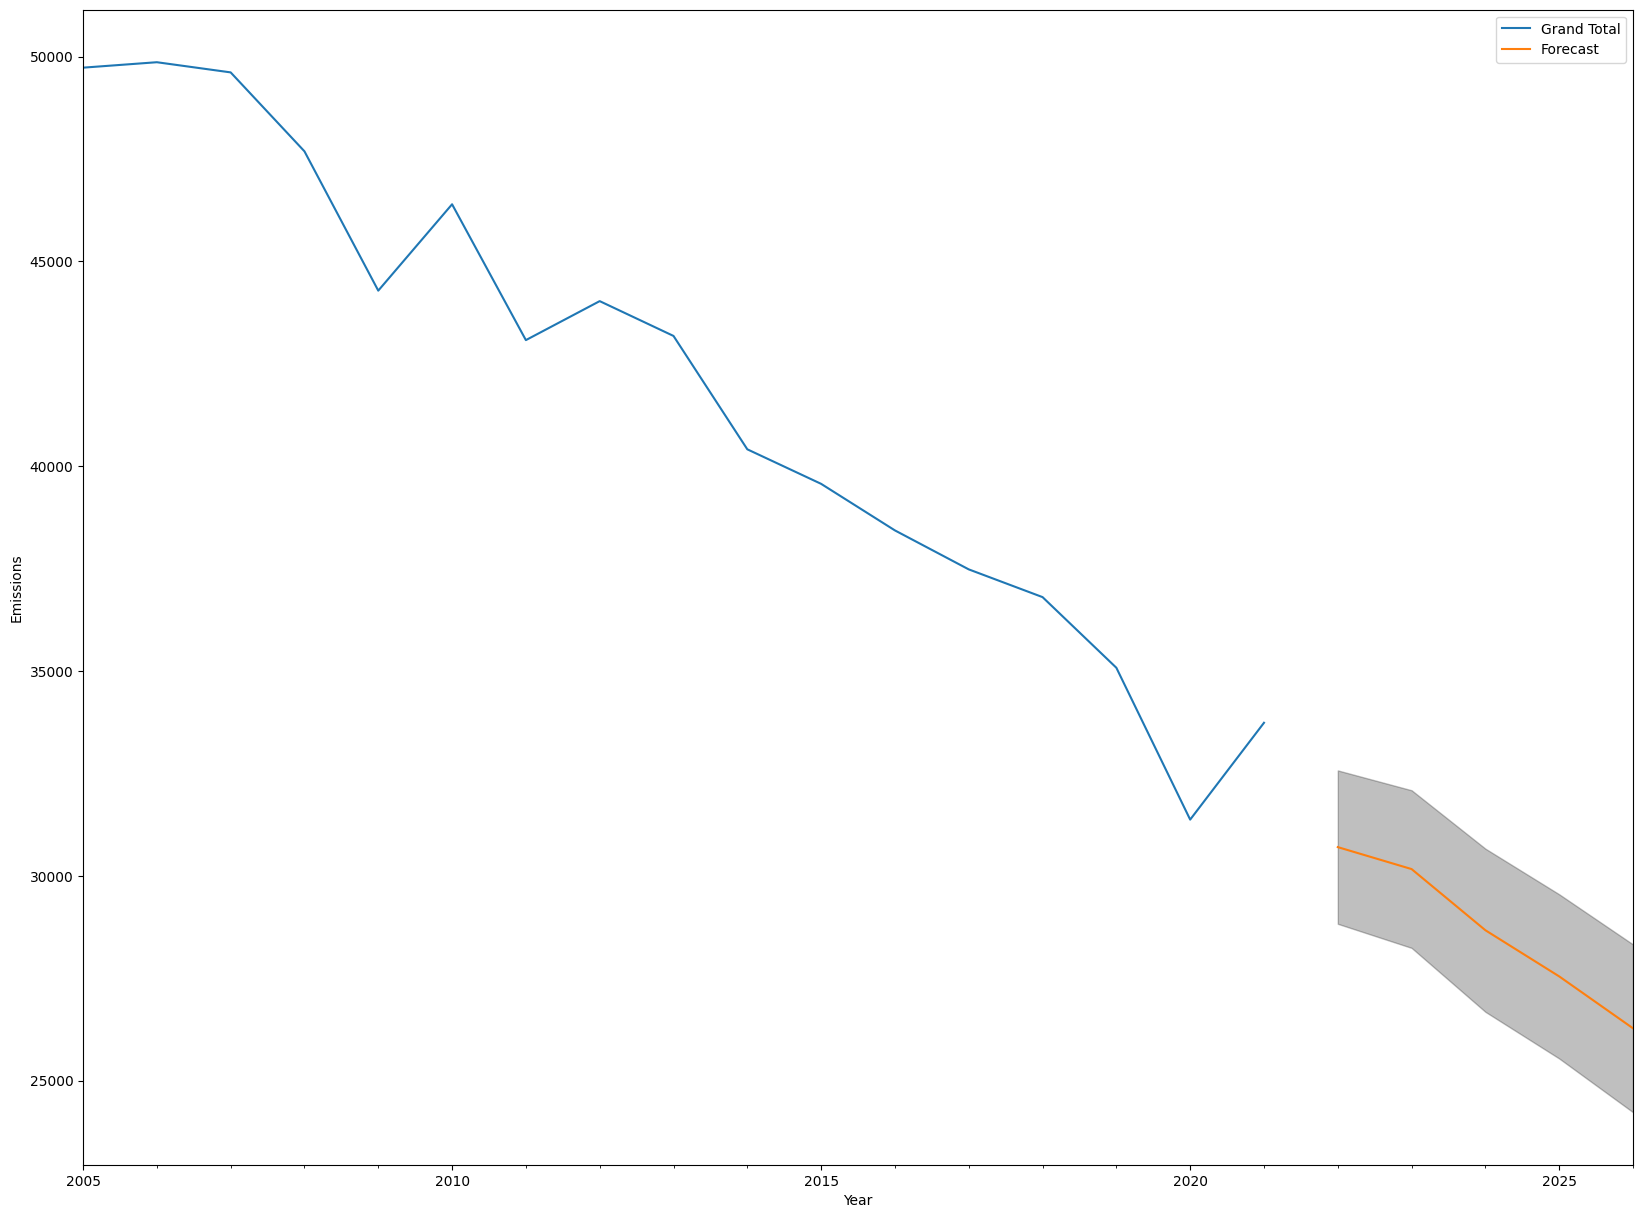

In [31]:

# Find the best SARIMAX parameters based on AIC and BIC
best_aic = np.inf
best_bic = np.inf
best_pdq = None
best_pdq_bic = None

for param in pdq:
    try:
        mod = SARIMAX(y,
                      order=param,
                      seasonal_order=(0, 0, 0, 0),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
        results = mod.fit()

        # Compare AIC
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param

        # Compare BIC
        if results.bic < best_bic:
            best_bic = results.bic
            best_pdq_bic = param

    except:
        continue

print(f'Best SARIMAX{best_pdq} - AIC:{best_aic}')
print(f'Best SARIMAX{best_pdq_bic} - BIC:{best_bic}')

# Fit the SARIMAX model with the best AIC
mod_aic = SARIMAX(y,
                  order=best_pdq,
                  seasonal_order=(0, 0, 0, 0),
                  enforce_stationarity=False,
                  enforce_invertibility=False)
results_aic = mod_aic.fit()
print('Model with best AIC')
print(results_aic.summary().tables[1])

# Fit the SARIMAX model with the best BIC
mod_bic = SARIMAX(y,
                  order=best_pdq_bic,
                  seasonal_order=(0, 0, 0, 0),
                  enforce_stationarity=False,
                  enforce_invertibility=False)
results_bic = mod_bic.fit()
print('Model with best BIC')
print(results_bic.summary().tables[1])

pred_uc = results_aic.get_forecast(steps=5)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='Observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Emissions')
plt.legend()
plt.show()


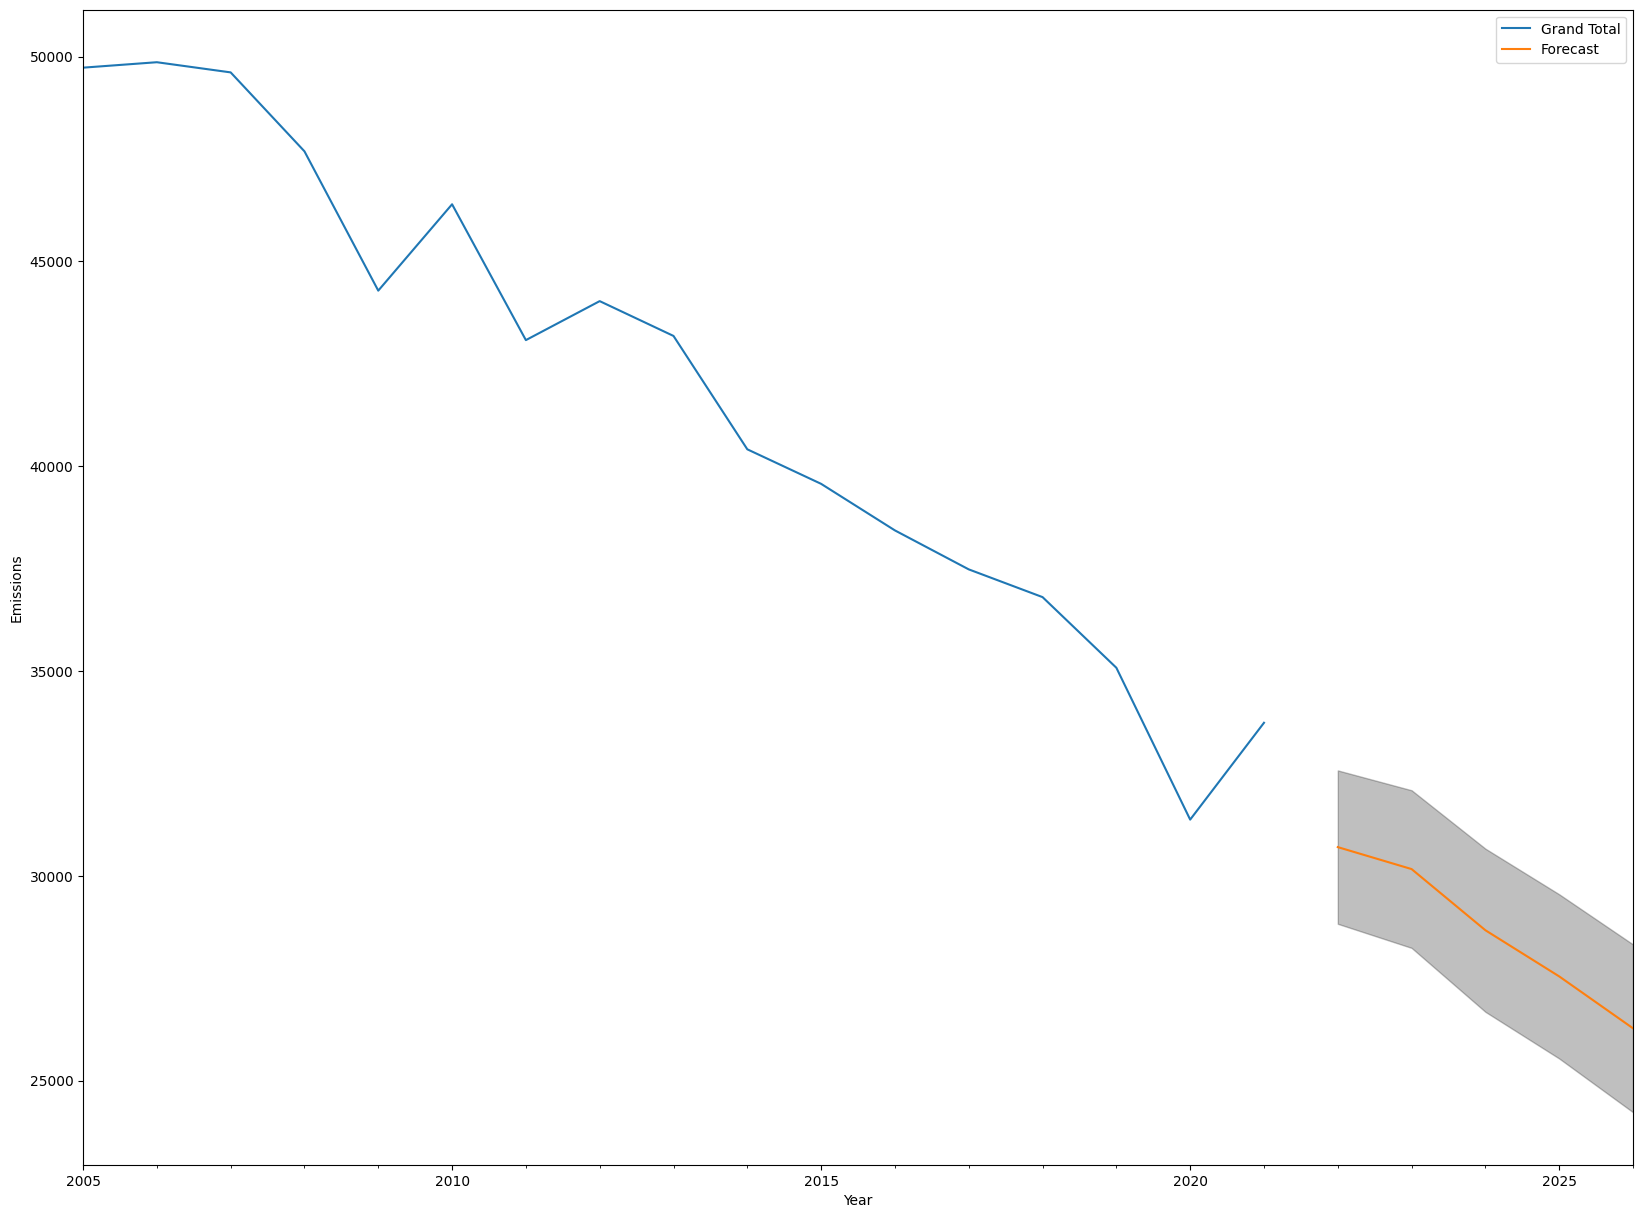

In [32]:
pred_uc = results_bic.get_forecast(steps=5)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='Observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Emissions')
plt.legend()
plt.show()

In [33]:

pred_uc = results_aic.get_forecast(steps=5)

forecasted_values = pred_uc.predicted_mean
print(forecasted_values)

print("Forecasted Values:")
for date, value in forecasted_values.items():
    print(f"{date.date()}: {value}")

pred_ci = pred_uc.conf_int()
print("\nConfidence Intervals:")
print(pred_ci)


2022-12-31    30701.048087
2023-12-31    30164.728162
2024-12-31    28671.137008
2025-12-31    27544.168324
2026-12-31    26276.787987
Freq: A-DEC, Name: predicted_mean, dtype: float64
Forecasted Values:
2022-12-31: 30701.04808657201
2023-12-31: 30164.728162097625
2024-12-31: 28671.137007755944
2025-12-31: 27544.168323873957
2026-12-31: 26276.78798689695

Confidence Intervals:
            lower Grand Total  upper Grand Total
2022-12-31       28828.393227       32573.702946
2023-12-31       28240.264460       32089.191864
2024-12-31       26678.925917       30663.348098
2025-12-31       25539.338342       29548.998305
2026-12-31       24228.171455       28325.404519


<h1>Fitting AMIMA (1,2,2) based on BIC and AIC Scores</h1>

In [34]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Filter out the specific warning message
warnings.simplefilter("ignore", category=Warning)


# Fitting the ARIMA model with the determined parameters (p=1, d=2, q=2)
model = ARIMA(yearly_emissions_['Grand Total'], order=(1, 2, 2))
model_fit = model.fit()

# Summarizing the model output
model_summary = model_fit.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Grand Total   No. Observations:                   17
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -141.313
Date:                Sat, 17 Feb 2024   AIC                            290.626
Time:                        14:10:13   BIC                            293.459
Sample:                    12-31-2005   HQIC                           290.596
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9987     66.862      0.015      0.988    -130.049     132.047
ma.L1         -1.0330     67.205     -0.015      0.988    -132.753     130.687
ma.L2          0.0341      2.267      0.015      0.988      -4.410       4.478
sigma2      8.862e+06      0.002   5.35e+09      0.000    8.86e+06    8.86e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.05   Jarque-Bera (JB):                 1.07
Prob(Q):                              0.02   Prob(JB):                         0.58
Heteroskedasticity (H):               0.63   Skew:                             0.64
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.9e+25. Standard errors may be unstable.
"""

In [35]:
# iterating over the ARIMA model
fitted_values = model_fit.predict(start=1, end=len(yearly_emissions_['Grand Total']))

# Printing the fitted values
print(fitted_values)

2006-12-31    93499.341756
2007-12-31    51359.081653
2008-12-31    49428.929339
2009-12-31    45822.386483
2010-12-31    40940.273643
2011-12-31    48319.548259
2012-12-31    39943.544877
2013-12-31    44844.564087
2014-12-31    42389.588701
2015-12-31    37714.246006
2016-12-31    38664.869470
2017-12-31    37305.480598
2018-12-31    36525.665255
2019-12-31    36119.017362
2020-12-31    33391.675258
2021-12-31    27735.428624
2022-12-31    35896.304793
Freq: A-DEC, Name: predicted_mean, dtype: float64


In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Actual values from 2005 to 2021
actual_values = [49865.040184, 49616.825647, 47689.374420, 44287.997799, 46396.818960,
                 43080.033683, 44031.880064, 43181.893928, 40413.744458, 39570.616279,
                 38433.656517, 37482.255734, 36805.003905, 35080.103036, 31372.640144,
                 33736.855308]

# Fitted values from your model for the same years
fitted_values = [51359.081653, 49428.929339, 45822.386483, 40940.273643, 48319.548259,
				 39943.544877, 44844.564087, 42389.588701, 37714.246006, 38664.869470,
				 37305.480598, 36525.665255, 36119.017362, 33391.675258, 27735.428624,
				 35896.304793]

mse = mean_squared_error(actual_values, fitted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, fitted_values)
r2 = r2_score(actual_values, fitted_values)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)


MSE: 3955776.864866506
RMSE: 1988.9134885324968
MAE: 1713.8715131250003
R2 Score: 0.8663706907379333


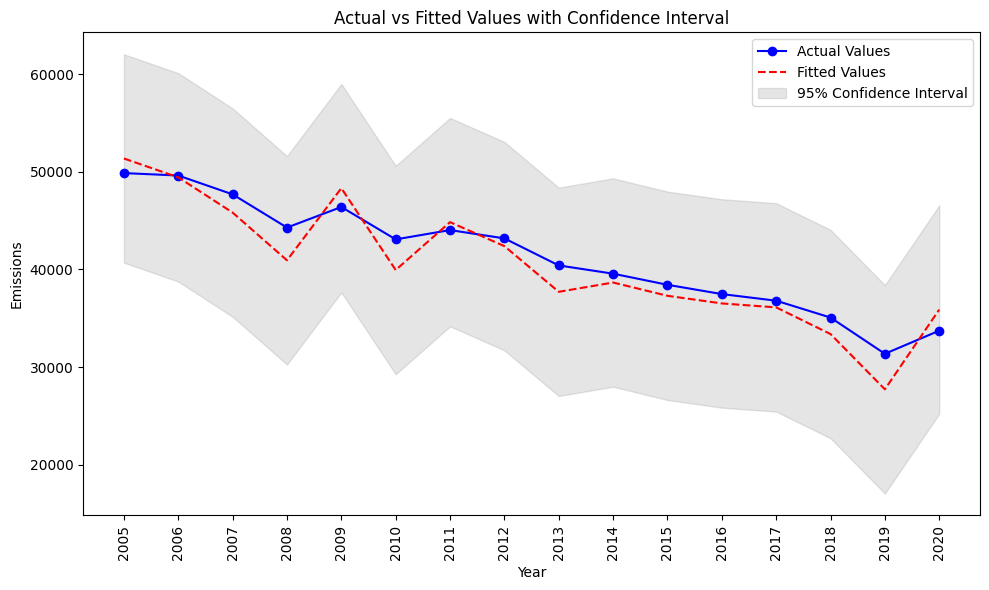

In [37]:
import matplotlib.pyplot as plt

years = range(2005, 2021)

# Actual and fitted values
actual_values = [49865.040184, 49616.825647, 47689.374420, 44287.997799, 46396.818960,
                 43080.033683, 44031.880064, 43181.893928, 40413.744458, 39570.616279,
                 38433.656517, 37482.255734, 36805.003905, 35080.103036, 31372.640144,
                 33736.855308]
fitted_values = [51359.081653, 49428.929339, 45822.386483, 40940.273643, 48319.548259,
				 39943.544877, 44844.564087, 42389.588701, 37714.246006, 38664.869470,
				 37305.480598, 36525.665255, 36119.017362, 33391.675258, 27735.428624,
				 35896.304793]

std_err = [np.std(actual_values)] * len(years)
ci_upper = [fitted + 1.96*err for fitted, err in zip(fitted_values, std_err)]
ci_lower = [fitted - 1.96*err for fitted, err in zip(fitted_values, std_err)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, actual_values, color='blue', marker='o', label='Actual Values')
plt.plot(years, fitted_values, color='red', linestyle='--', label='Fitted Values')
plt.fill_between(years, ci_lower, ci_upper, color='grey', alpha=0.2, label='95% Confidence Interval')
plt.title('Actual vs Fitted Values with Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.xticks(years, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

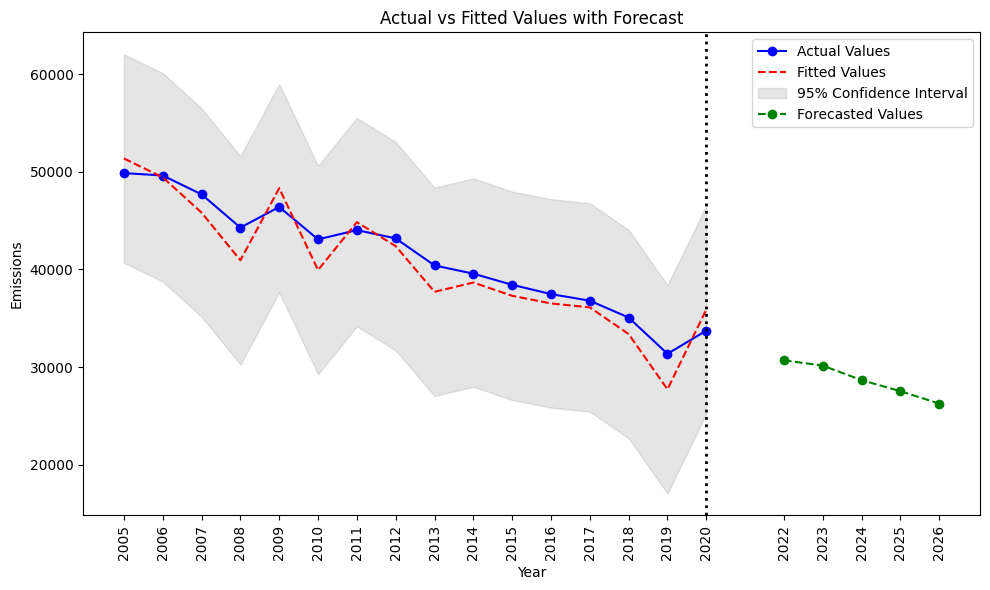

In [38]:
import matplotlib.pyplot as plt
import numpy as np

years = list(range(2005, 2021))
actual_values = [49865.040184, 49616.825647, 47689.374420, 44287.997799, 46396.818960,
                 43080.033683, 44031.880064, 43181.893928, 40413.744458, 39570.616279,
                 38433.656517, 37482.255734, 36805.003905, 35080.103036, 31372.640144,
                 33736.855308]
fitted_values = [51359.081653, 49428.929339, 45822.386483, 40940.273643, 48319.548259,
                 39943.544877, 44844.564087, 42389.588701, 37714.246006, 38664.869470,
                 37305.480598, 36525.665255, 36119.017362, 33391.675258, 27735.428624,
                 35896.304793]

forecast_years = [2022, 2023, 2024, 2025, 2026]
forecast_values = [30701.048087, 30164.728162, 28671.137008, 27544.168324, 26276.787987]

extended_years = years + forecast_years
all_fitted_values = fitted_values + forecast_values

std_err = [np.std(actual_values)] * len(years)
ci_upper = [fitted + 1.96*err for fitted, err in zip(fitted_values, std_err)]
ci_lower = [fitted - 1.96*err for fitted, err in zip(fitted_values, std_err)]

plt.figure(figsize=(10, 6))
plt.plot(years, actual_values, color='blue', marker='o', label='Actual Values')
plt.plot(years, fitted_values, color='red', linestyle='--', label='Fitted Values')
plt.fill_between(years, ci_lower, ci_upper, color='grey', alpha=0.2, label='95% Confidence Interval')

plt.plot(forecast_years, forecast_values, color='green', linestyle='--', marker='o', label='Forecasted Values')

plt.axvline(x=years[-1], color='black', linestyle=':', linewidth=2)

plt.title('Actual vs Fitted Values with Forecast')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.xticks(extended_years, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

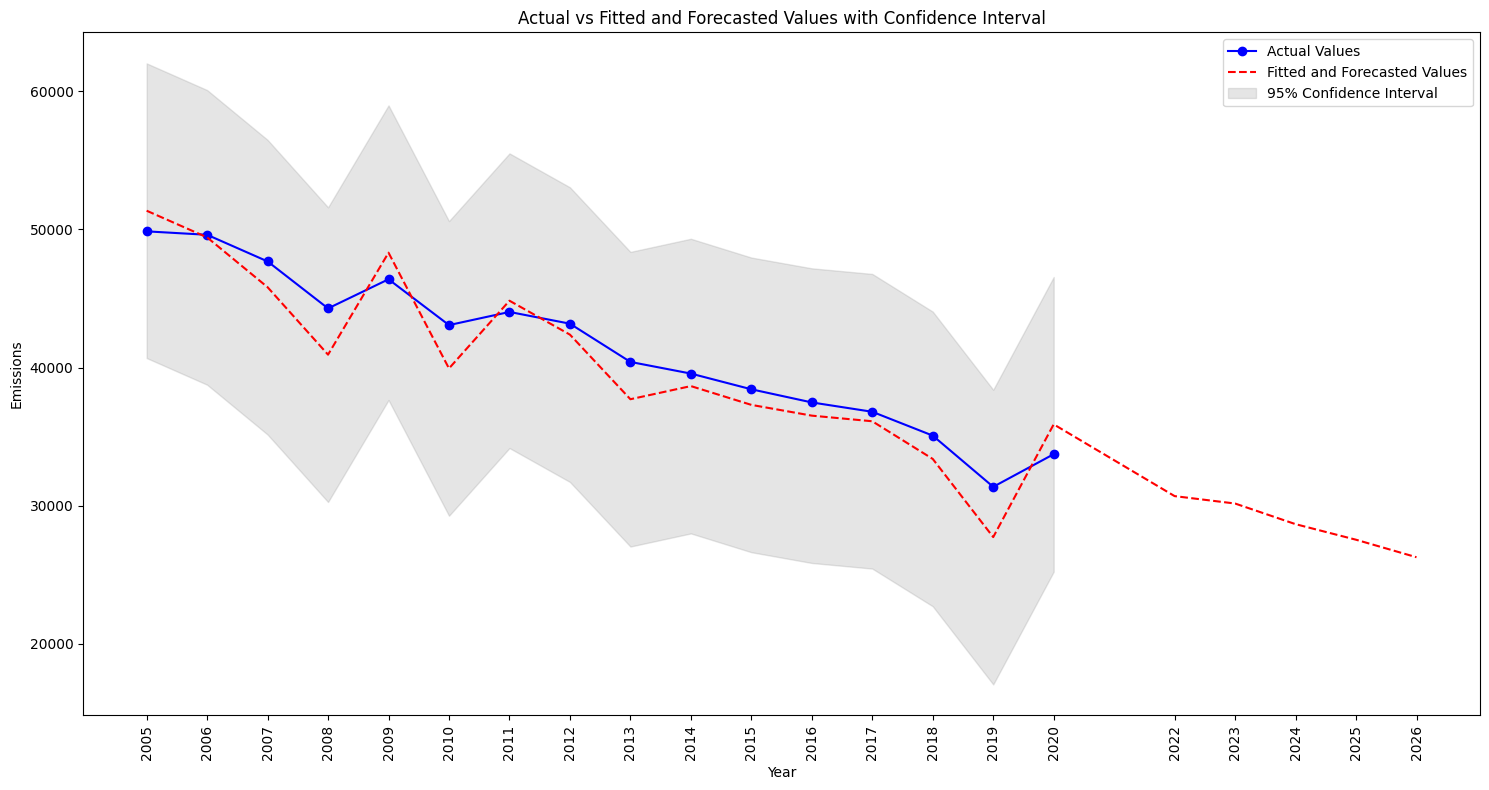

In [39]:
import matplotlib.pyplot as plt
import numpy as np

years = list(range(2005, 2021))
actual_values = [49865.040184, 49616.825647, 47689.374420, 44287.997799, 46396.818960,
                 43080.033683, 44031.880064, 43181.893928, 40413.744458, 39570.616279,
                 38433.656517, 37482.255734, 36805.003905, 35080.103036, 31372.640144,
                 33736.855308]
fitted_values = [51359.081653, 49428.929339, 45822.386483, 40940.273643, 48319.548259,
                 39943.544877, 44844.564087, 42389.588701, 37714.246006, 38664.869470,
                 37305.480598, 36525.665255, 36119.017362, 33391.675258, 27735.428624,
                 35896.304793]

forecast_years = [2021, 2022, 2023, 2024, 2025, 2026]
forecast_values = [35896.304793, 30701.048087, 30164.728162, 28671.137008, 27544.168324, 26276.787987]

# Combine existing and forecasted years and values
extended_years = years + forecast_years[1:]
all_fitted_values = fitted_values + forecast_values[1:]

std_err = np.std(actual_values)
ci_upper = [fit + 1.96*std_err for fit in fitted_values]
ci_lower = [fit - 1.96*std_err for fit in fitted_values]

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(years, actual_values, color='blue', marker='o', label='Actual Values')
plt.plot(extended_years, all_fitted_values, color='red', linestyle='--', label='Fitted and Forecasted Values')
plt.fill_between(years, ci_lower, ci_upper, color='grey', alpha=0.2, label='95% Confidence Interval')

plt.title('Actual vs Fitted and Forecasted Values with Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.xticks(extended_years, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


<h1>LSTM</h1>

In [6]:
# 1. Data Preparation
import pandas as pd

url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1166194/2005-21-uk-local-authority-ghg-emissions.xlsx'
data_1_1_cleaned = pd.read_excel(url, sheet_name='1_1', skiprows=4)

In [7]:
# Filter the data for the "West Midlands" Region/Country
data_1_1_cleaned = data_1_1_cleaned[data_1_1_cleaned['Region/Country'] == 'West Midlands']
# Filter out rows where "Second Tier Authority" ends with "Total"
data_1_1_cleaned = data_1_1_cleaned[~data_1_1_cleaned['Second Tier Authority'].str.endswith("Total")]

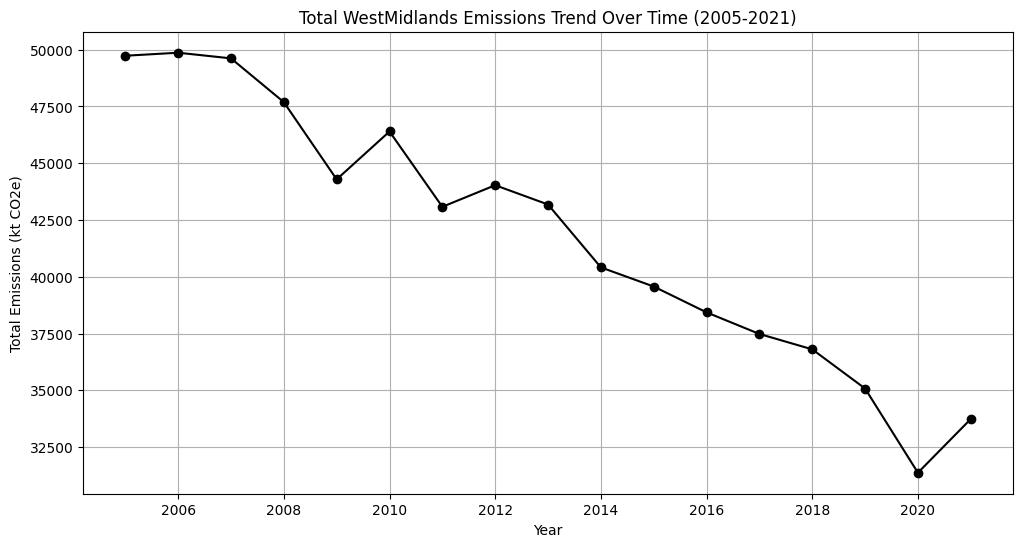

Calendar Year
2005    49732.222417
2006    49865.040184
2007    49616.825647
2008    47689.374420
2009    44287.997799
2010    46396.818960
2011    43080.033683
2012    44031.880064
2013    43181.893928
2014    40413.744458
2015    39570.616279
2016    38433.656517
2017    37482.255734
2018    36805.003905
2019    35080.103036
2020    31372.640144
2021    33736.855308
Name: Grand Total, dtype: float64

In [8]:
import matplotlib.pyplot as plt

# Group by 'Calendar Year' and sum the 'Grand Total' column to get total emissions for each year
yearly_emissions = data_1_1_cleaned.groupby('Calendar Year')['Grand Total'].sum()

yearly_emissions_ = pd.DataFrame(yearly_emissions)

# Plotting the trend over time
plt.figure(figsize=(12, 6))
yearly_emissions.plot(marker='o', linestyle='-', color='black')
plt.title('Total WestMidlands Emissions Trend Over Time (2005-2021)')
plt.xlabel('Year')
plt.ylabel('Total Emissions (kt CO2e)')
plt.grid(True)
plt.show()
yearly_emissions

<Figure size 1500x800 with 0 Axes>

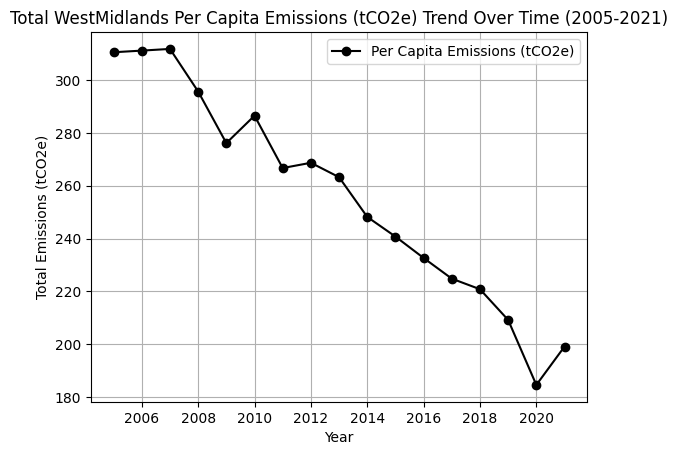

Per Capita Emissions (tCO2e)
Calendar Year                              
2005                             310.595150
2006                             311.217078
2007                             311.856107
2008                             295.716888
2009                             276.157382
2010                             286.558538
2011                             266.708961
2012                             268.706621
2013                             263.247085
2014                             248.190051
2015                             240.737506
2016                             232.626905
2017                             224.787280
2018                             220.782414
2019                             209.135109
2020                             184.513159
2021                             199.046467

In [15]:
import matplotlib.pyplot as plt

# Group by 'Calendar Year' and sum the 'Grand Total' column to get total emissions for each year
yearly_emissions_ = data_1_1_cleaned.groupby('Calendar Year')['Per Capita Emissions (tCO2e)'].sum()

yearly_emissions_ = pd.DataFrame(yearly_emissions_)

# Plotting the trend over time
#plt.figure(figsize=(12, 6))
plt.figure(figsize=(15, 8))
yearly_emissions_.plot(marker='o', linestyle='-', color='black')
plt.title('Total WestMidlands Per Capita Emissions (tCO2e) Trend Over Time (2005-2021)')
plt.xlabel('Year')
plt.ylabel('Total Emissions (tCO2e)')
plt.grid(True)
plt.show()
yearly_emissions_

In [43]:
pip install tensorflow

In [44]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Convert the Series to a DataFrame
yearly_emissions_df = yearly_emissions.to_frame()

# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_emissions = scaler.fit_transform(yearly_emissions_df)

# Spliting the data into training and testing sets
train_size = int(len(scaled_emissions) * 0.8)
test_size = len(scaled_emissions) - train_size
train, test = scaled_emissions[0:train_size,:], scaled_emissions[train_size:len(scaled_emissions),:]

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape the data into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, validation_data=(testX, testY))

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions to original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


# Calculate root mean squared error
trainScore = np.sqrt(np.mean((trainPredict[:,0] - trainY[0]) ** 2))
testScore = np.sqrt(np.mean((testPredict[:,0] - testY[0]) ** 2))

print('Train Score: %.2f RMSE' % trainScore)
print('Test Score: %.2f RMSE' % testScore)

Epoch 1/100
11/11 - 3s - loss: 0.4523 - val_loss: 0.0136 - 3s/epoch - 233ms/step
Epoch 2/100
11/11 - 0s - loss: 0.4164 - val_loss: 0.0110 - 59ms/epoch - 5ms/step
Epoch 3/100
11/11 - 0s - loss: 0.3795 - val_loss: 0.0096 - 51ms/epoch - 5ms/step
Epoch 4/100
11/11 - 0s - loss: 0.3475 - val_loss: 0.0091 - 67ms/epoch - 6ms/step
Epoch 5/100
11/11 - 0s - loss: 0.3140 - val_loss: 0.0096 - 66ms/epoch - 6ms/step
Epoch 6/100
11/11 - 0s - loss: 0.2853 - val_loss: 0.0111 - 69ms/epoch - 6ms/step
Epoch 7/100
11/11 - 0s - loss: 0.2581 - val_loss: 0.0136 - 71ms/epoch - 6ms/step
Epoch 8/100
11/11 - 0s - loss: 0.2296 - val_loss: 0.0169 - 51ms/epoch - 5ms/step
Epoch 9/100
11/11 - 0s - loss: 0.2057 - val_loss: 0.0210 - 56ms/epoch - 5ms/step
Epoch 10/100
11/11 - 0s - loss: 0.1826 - val_loss: 0.0259 - 61ms/epoch - 6ms/step
Epoch 11/100
11/11 - 0s - loss: 0.1618 - val_loss: 0.0316 - 55ms/epoch - 5ms/step
Epoch 12/100
11/11 - 0s - loss: 0.1434 - val_loss: 0.0382 - 75ms/epoch - 7ms/step
Epoch 13/100
11/11 - 0s -

In [45]:
trainX.shape

(11, 1, 1)

In [46]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Convert the Series to a DataFrame
yearly_emissions_df = yearly_emissions.to_frame()

# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_emissions = scaler.fit_transform(yearly_emissions_df)

# Spliting the data into training and testing sets
train_size = int(len(scaled_emissions) * 0.8)
test_size = len(scaled_emissions) - train_size
train, test = scaled_emissions[0:train_size,:], scaled_emissions[train_size:len(scaled_emissions),:]

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape the data into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, validation_data=(testX, testY))

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions to original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


# Calculate root mean squared error
trainScore = np.sqrt(np.mean((trainPredict[:,0] - trainY[0]) ** 2))
testScore = np.sqrt(np.mean((testPredict[:,0] - testY[0]) ** 2))

print('Train Score: %.2f RMSE' % trainScore)
print('Test Score: %.2f RMSE' % testScore)

Epoch 1/100
11/11 - 3s - loss: 0.7402 - val_loss: 0.0269 - 3s/epoch - 232ms/step
Epoch 2/100
11/11 - 0s - loss: 0.6904 - val_loss: 0.0222 - 54ms/epoch - 5ms/step
Epoch 3/100
11/11 - 0s - loss: 0.6472 - val_loss: 0.0182 - 56ms/epoch - 5ms/step
Epoch 4/100
11/11 - 0s - loss: 0.6017 - val_loss: 0.0152 - 65ms/epoch - 6ms/step
Epoch 5/100
11/11 - 0s - loss: 0.5633 - val_loss: 0.0130 - 51ms/epoch - 5ms/step
Epoch 6/100
11/11 - 0s - loss: 0.5226 - val_loss: 0.0116 - 56ms/epoch - 5ms/step
Epoch 7/100
11/11 - 0s - loss: 0.4868 - val_loss: 0.0109 - 68ms/epoch - 6ms/step
Epoch 8/100
11/11 - 0s - loss: 0.4507 - val_loss: 0.0111 - 55ms/epoch - 5ms/step
Epoch 9/100
11/11 - 0s - loss: 0.4151 - val_loss: 0.0120 - 68ms/epoch - 6ms/step
Epoch 10/100
11/11 - 0s - loss: 0.3816 - val_loss: 0.0136 - 53ms/epoch - 5ms/step
Epoch 11/100
11/11 - 0s - loss: 0.3513 - val_loss: 0.0160 - 55ms/epoch - 5ms/step
Epoch 12/100
11/11 - 0s - loss: 0.3237 - val_loss: 0.0194 - 52ms/epoch - 5ms/step
Epoch 13/100
11/11 - 0s -

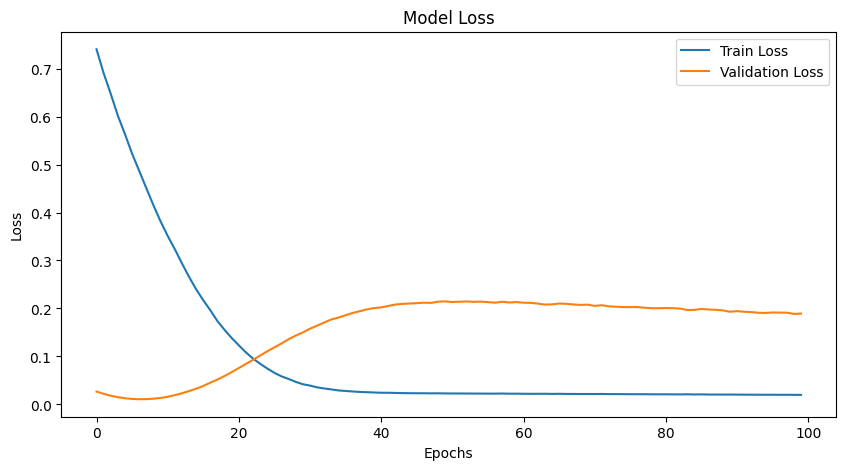

In [47]:
# Plot the training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

<h1>Calibrating LSTM</h1>

In [48]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.1 MB/s eta 0:00:00


In [49]:
import optuna
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Define the objective function for optimization
def objective(trial):
    # Hyperparameters to optimize
    lstm_units = trial.suggest_categorical('lstm_units', [4, 8, 16, 32])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [1, 8, 16, 32])

    # Load and preprocess data
    yearly_emissions_df = yearly_emissions.to_frame()
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_emissions = scaler.fit_transform(yearly_emissions_df)
    train_size = int(len(scaled_emissions) * 0.8)
    train, test = scaled_emissions[0:train_size,:], scaled_emissions[train_size:len(scaled_emissions),:]
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # Create and compile the LSTM model
    model = Sequential([
        LSTM(lstm_units, input_shape=(1, look_back)),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit the model
    history = model.fit(trainX, trainY, epochs=100, batch_size=batch_size, verbose=0, validation_data=(testX, testY))

    # Make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Invert predictions to original scale
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY_inv = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY_inv = scaler.inverse_transform([testY])

    # Calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(trainY_inv[0], trainPredict[:,0]))
    testScore = np.sqrt(mean_squared_error(testY_inv[0], testPredict[:,0]))

    return testScore

# Define the dataset creation function
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print the best trial's parameters and the best value achieved
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-02-17 14:11:56,384] A new study created in memory with name: no-name-783a1c99-9f57-4eb0-9340-1cc70351025c


1/1 [==============================] - 0s 31ms/step


[I 2024-02-17 14:12:08,031] Trial 0 finished with value: 3766.3172337571555 and parameters: {'lstm_units': 16, 'dropout_rate': 0.04999406392420641, 'learning_rate': 8.624554045266214e-05, 'batch_size': 32}. Best is trial 0 with value: 3766.3172337571555.


1/1 [==============================] - 0s 55ms/step


[I 2024-02-17 14:12:33,939] Trial 1 finished with value: 3612.1034543218616 and parameters: {'lstm_units': 16, 'dropout_rate': 0.07529370845309563, 'learning_rate': 0.0005915555795036627, 'batch_size': 16}. Best is trial 1 with value: 3612.1034543218616.


1/1 [==============================] - 0s 30ms/step


[I 2024-02-17 14:12:50,363] Trial 2 finished with value: 5450.523588517934 and parameters: {'lstm_units': 8, 'dropout_rate': 0.3031401819026507, 'learning_rate': 0.00042688773489534795, 'batch_size': 8}. Best is trial 1 with value: 3612.1034543218616.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:13:02,681] Trial 3 finished with value: 6282.581214885246 and parameters: {'lstm_units': 4, 'dropout_rate': 0.11869529858729039, 'learning_rate': 1.2080725443191717e-05, 'batch_size': 1}. Best is trial 1 with value: 3612.1034543218616.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:13:09,443] Trial 4 finished with value: 2278.1130921678123 and parameters: {'lstm_units': 8, 'dropout_rate': 0.09418308320114915, 'learning_rate': 0.0003688784615642846, 'batch_size': 32}. Best is trial 4 with value: 2278.1130921678123.


1/1 [==============================] - 0s 33ms/step


[I 2024-02-17 14:13:17,419] Trial 5 finished with value: 6082.084884673105 and parameters: {'lstm_units': 16, 'dropout_rate': 0.17819523235968948, 'learning_rate': 0.00016516916098826756, 'batch_size': 1}. Best is trial 4 with value: 2278.1130921678123.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:13:23,625] Trial 6 finished with value: 3431.2223029105457 and parameters: {'lstm_units': 4, 'dropout_rate': 0.17892608179312292, 'learning_rate': 0.0066220691935452835, 'batch_size': 8}. Best is trial 4 with value: 2278.1130921678123.


1/1 [==============================] - 0s 22ms/step


[I 2024-02-17 14:13:32,256] Trial 7 finished with value: 7335.223059486488 and parameters: {'lstm_units': 4, 'dropout_rate': 0.08751455581021628, 'learning_rate': 0.0033085655803279162, 'batch_size': 1}. Best is trial 4 with value: 2278.1130921678123.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:13:39,361] Trial 8 finished with value: 1920.3930739582659 and parameters: {'lstm_units': 4, 'dropout_rate': 0.2399509064407187, 'learning_rate': 0.00011369045029926342, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:13:46,162] Trial 9 finished with value: 4914.756114826082 and parameters: {'lstm_units': 32, 'dropout_rate': 0.03558852697888809, 'learning_rate': 2.6869799778025368e-05, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:13:51,870] Trial 10 finished with value: 4710.688295843504 and parameters: {'lstm_units': 32, 'dropout_rate': 0.45944369608778285, 'learning_rate': 0.001850082025545974, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:13:58,337] Trial 11 finished with value: 2914.243539520652 and parameters: {'lstm_units': 8, 'dropout_rate': 0.3162251629397832, 'learning_rate': 7.826824428726106e-05, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 33ms/step


[I 2024-02-17 14:14:06,286] Trial 12 finished with value: 3536.071573755221 and parameters: {'lstm_units': 8, 'dropout_rate': 0.2322732278344826, 'learning_rate': 0.0005094571510456966, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 22ms/step


[I 2024-02-17 14:14:12,298] Trial 13 finished with value: 2786.4627941228873 and parameters: {'lstm_units': 4, 'dropout_rate': 0.405550978506465, 'learning_rate': 0.0011879551868624759, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:14:19,922] Trial 14 finished with value: 2847.5904976962192 and parameters: {'lstm_units': 8, 'dropout_rate': 0.15720675338148293, 'learning_rate': 0.00013767178858223054, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:14:25,685] Trial 15 finished with value: 2117.3832173976775 and parameters: {'lstm_units': 4, 'dropout_rate': 0.25741932575697085, 'learning_rate': 4.361712341821866e-05, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:14:32,593] Trial 16 finished with value: 1965.1841995644356 and parameters: {'lstm_units': 4, 'dropout_rate': 0.2828392087276834, 'learning_rate': 3.531022093739836e-05, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:14:38,480] Trial 17 finished with value: 4473.760641020033 and parameters: {'lstm_units': 4, 'dropout_rate': 0.363835000493687, 'learning_rate': 1.0179626484226353e-05, 'batch_size': 8}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:14:44,942] Trial 18 finished with value: 2707.872943762686 and parameters: {'lstm_units': 4, 'dropout_rate': 0.23928852611692578, 'learning_rate': 2.6851308855558835e-05, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 34ms/step


[I 2024-02-17 14:14:53,584] Trial 19 finished with value: 2484.0703947955362 and parameters: {'lstm_units': 4, 'dropout_rate': 0.31763988496119144, 'learning_rate': 0.0002032462606755173, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:15:01,906] Trial 20 finished with value: 5055.942971843761 and parameters: {'lstm_units': 32, 'dropout_rate': 0.48275850595599884, 'learning_rate': 5.088641263435107e-05, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 21ms/step


[I 2024-02-17 14:15:08,672] Trial 21 finished with value: 2679.338570223961 and parameters: {'lstm_units': 4, 'dropout_rate': 0.2693227158036082, 'learning_rate': 4.269168121592453e-05, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 21ms/step


[I 2024-02-17 14:15:14,525] Trial 22 finished with value: 1990.5732254615768 and parameters: {'lstm_units': 4, 'dropout_rate': 0.21433748948925466, 'learning_rate': 2.1445129870668e-05, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:15:21,045] Trial 23 finished with value: 2281.2688206464954 and parameters: {'lstm_units': 4, 'dropout_rate': 0.20658009888095044, 'learning_rate': 2.1563254464847546e-05, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:15:26,725] Trial 24 finished with value: 2087.9419723291076 and parameters: {'lstm_units': 4, 'dropout_rate': 0.38194950261012695, 'learning_rate': 1.7631913855694657e-05, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 22ms/step


[I 2024-02-17 14:15:33,249] Trial 25 finished with value: 2070.9331946006105 and parameters: {'lstm_units': 4, 'dropout_rate': 0.13823311318471732, 'learning_rate': 8.600765097552848e-05, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:15:39,018] Trial 26 finished with value: 2304.605674127127 and parameters: {'lstm_units': 4, 'dropout_rate': 0.2885767632127841, 'learning_rate': 5.504898536528513e-05, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 22ms/step


[I 2024-02-17 14:15:53,208] Trial 27 finished with value: 7663.273590152963 and parameters: {'lstm_units': 4, 'dropout_rate': 0.001906738920836204, 'learning_rate': 0.00020115755068490757, 'batch_size': 1}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:16:00,068] Trial 28 finished with value: 6702.945675153426 and parameters: {'lstm_units': 16, 'dropout_rate': 0.3523888207117801, 'learning_rate': 1.5635893799369863e-05, 'batch_size': 8}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 27ms/step


[I 2024-02-17 14:16:06,089] Trial 29 finished with value: 4721.24688488926 and parameters: {'lstm_units': 32, 'dropout_rate': 0.21082608554829863, 'learning_rate': 0.0001101894614902389, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 28ms/step


[I 2024-02-17 14:16:14,272] Trial 30 finished with value: 3353.4206847323007 and parameters: {'lstm_units': 16, 'dropout_rate': 0.19767907911120736, 'learning_rate': 3.0559900940169084e-05, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:16:20,939] Trial 31 finished with value: 1960.4492881763297 and parameters: {'lstm_units': 4, 'dropout_rate': 0.14565903576745282, 'learning_rate': 8.655968628203735e-05, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:16:26,854] Trial 32 finished with value: 2134.7539923349673 and parameters: {'lstm_units': 4, 'dropout_rate': 0.14881105099418487, 'learning_rate': 7.15905693355499e-05, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:16:33,357] Trial 33 finished with value: 2560.4825566075215 and parameters: {'lstm_units': 4, 'dropout_rate': 0.27944020830530075, 'learning_rate': 0.00024815423505140065, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:16:39,361] Trial 34 finished with value: 2244.8162381595753 and parameters: {'lstm_units': 4, 'dropout_rate': 0.223000154142807, 'learning_rate': 3.510747485594112e-05, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:16:45,855] Trial 35 finished with value: 1950.9667135683048 and parameters: {'lstm_units': 4, 'dropout_rate': 0.11065987294215515, 'learning_rate': 0.00012326197312101413, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:16:52,882] Trial 36 finished with value: 4160.267434607853 and parameters: {'lstm_units': 16, 'dropout_rate': 0.11201071477004589, 'learning_rate': 0.0007159321374737172, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 21ms/step


[I 2024-02-17 14:16:59,262] Trial 37 finished with value: 2124.861641714365 and parameters: {'lstm_units': 4, 'dropout_rate': 0.05287638994466103, 'learning_rate': 0.0001489742049678868, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:17:04,938] Trial 38 finished with value: 1940.5459538775845 and parameters: {'lstm_units': 4, 'dropout_rate': 0.11654134234383771, 'learning_rate': 0.00029378412657404937, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 21ms/step


[I 2024-02-17 14:17:11,678] Trial 39 finished with value: 1936.0115516315475 and parameters: {'lstm_units': 4, 'dropout_rate': 0.1160378447578913, 'learning_rate': 0.00031145242118964803, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:17:17,575] Trial 40 finished with value: 3285.475281236031 and parameters: {'lstm_units': 8, 'dropout_rate': 0.06787301058881925, 'learning_rate': 0.0003664150453212642, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:17:23,866] Trial 41 finished with value: 2160.8217195623797 and parameters: {'lstm_units': 4, 'dropout_rate': 0.10929878829130835, 'learning_rate': 0.0002703576556310201, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 23ms/step


[I 2024-02-17 14:17:31,794] Trial 42 finished with value: 2089.7080401006233 and parameters: {'lstm_units': 4, 'dropout_rate': 0.17305873104528396, 'learning_rate': 0.0006969431501918815, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:17:37,744] Trial 43 finished with value: 2514.4683299619946 and parameters: {'lstm_units': 4, 'dropout_rate': 0.12725246144093097, 'learning_rate': 0.00011092149278246488, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:17:44,208] Trial 44 finished with value: 5287.637811548753 and parameters: {'lstm_units': 32, 'dropout_rate': 0.09557077599488722, 'learning_rate': 0.0009750096378477214, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:17:51,212] Trial 45 finished with value: 2437.3501721105836 and parameters: {'lstm_units': 4, 'dropout_rate': 0.024745815323300155, 'learning_rate': 0.00041603266305227415, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:17:59,395] Trial 46 finished with value: 6692.526998462416 and parameters: {'lstm_units': 16, 'dropout_rate': 0.07635507570630573, 'learning_rate': 0.00012153618271833831, 'batch_size': 1}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:18:05,353] Trial 47 finished with value: 3041.0702552341636 and parameters: {'lstm_units': 4, 'dropout_rate': 0.17840272294916093, 'learning_rate': 0.0002984476487642284, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:18:12,022] Trial 48 finished with value: 5441.332902456506 and parameters: {'lstm_units': 8, 'dropout_rate': 0.04778507619757563, 'learning_rate': 0.0001853824211140569, 'batch_size': 8}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 28ms/step


[I 2024-02-17 14:18:17,724] Trial 49 finished with value: 2637.8271175150358 and parameters: {'lstm_units': 4, 'dropout_rate': 0.1647766600292418, 'learning_rate': 6.205669874856577e-05, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:18:25,856] Trial 50 finished with value: 8919.138741396277 and parameters: {'lstm_units': 4, 'dropout_rate': 0.13407517417056855, 'learning_rate': 0.0005848431634522311, 'batch_size': 1}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 21ms/step


[I 2024-02-17 14:18:32,659] Trial 51 finished with value: 3175.249989802791 and parameters: {'lstm_units': 4, 'dropout_rate': 0.32081921472313146, 'learning_rate': 8.973196500226169e-05, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:18:38,246] Trial 52 finished with value: 2367.3514619200787 and parameters: {'lstm_units': 4, 'dropout_rate': 0.09720638385342105, 'learning_rate': 0.0072657498919600945, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 21ms/step


[I 2024-02-17 14:18:46,027] Trial 53 finished with value: 4915.5372250305345 and parameters: {'lstm_units': 4, 'dropout_rate': 0.24586917987693632, 'learning_rate': 0.00015880135074462066, 'batch_size': 8}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:18:52,005] Trial 54 finished with value: 2385.0119350447785 and parameters: {'lstm_units': 4, 'dropout_rate': 0.15335529619674962, 'learning_rate': 0.002601260358519523, 'batch_size': 16}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:18:59,915] Trial 55 finished with value: 5188.900092889333 and parameters: {'lstm_units': 32, 'dropout_rate': 0.18954775899277315, 'learning_rate': 0.0002164481478842439, 'batch_size': 32}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 25ms/step


[I 2024-02-17 14:19:14,005] Trial 56 finished with value: 6337.521326653288 and parameters: {'lstm_units': 4, 'dropout_rate': 0.0700252674070435, 'learning_rate': 9.1992554846513e-05, 'batch_size': 1}. Best is trial 8 with value: 1920.3930739582659.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:19:20,436] Trial 57 finished with value: 1897.636086363315 and parameters: {'lstm_units': 4, 'dropout_rate': 0.33961170632894955, 'learning_rate': 0.00032926518891158795, 'batch_size': 32}. Best is trial 57 with value: 1897.636086363315.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:19:26,096] Trial 58 finished with value: 2860.692476634963 and parameters: {'lstm_units': 8, 'dropout_rate': 0.4148234748147749, 'learning_rate': 0.000518788350717853, 'batch_size': 16}. Best is trial 57 with value: 1897.636086363315.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:19:32,732] Trial 59 finished with value: 2286.458193586997 and parameters: {'lstm_units': 4, 'dropout_rate': 0.3445252163604835, 'learning_rate': 0.0003415885956291484, 'batch_size': 32}. Best is trial 57 with value: 1897.636086363315.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:19:38,707] Trial 60 finished with value: 5122.171216607478 and parameters: {'lstm_units': 4, 'dropout_rate': 0.42822862874360623, 'learning_rate': 0.0012118724695159328, 'batch_size': 8}. Best is trial 57 with value: 1897.636086363315.


1/1 [==============================] - 0s 21ms/step


[I 2024-02-17 14:19:45,281] Trial 61 finished with value: 2020.723485576794 and parameters: {'lstm_units': 4, 'dropout_rate': 0.29713999827474163, 'learning_rate': 4.16359319653425e-05, 'batch_size': 32}. Best is trial 57 with value: 1897.636086363315.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:19:51,099] Trial 62 finished with value: 2015.4537776497896 and parameters: {'lstm_units': 4, 'dropout_rate': 0.2673330222086188, 'learning_rate': 0.00013642837276086473, 'batch_size': 32}. Best is trial 57 with value: 1897.636086363315.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:19:57,912] Trial 63 finished with value: 1997.7625790740144 and parameters: {'lstm_units': 4, 'dropout_rate': 0.3767627498593181, 'learning_rate': 7.121874284162856e-05, 'batch_size': 32}. Best is trial 57 with value: 1897.636086363315.


1/1 [==============================] - 0s 21ms/step


[I 2024-02-17 14:20:04,157] Trial 64 finished with value: 1893.1354722184692 and parameters: {'lstm_units': 4, 'dropout_rate': 0.31686720442525995, 'learning_rate': 0.0002443535489534407, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 22ms/step


[I 2024-02-17 14:20:11,207] Trial 65 finished with value: 1913.0693591685788 and parameters: {'lstm_units': 4, 'dropout_rate': 0.32889415807416933, 'learning_rate': 0.00024472446856534807, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 27ms/step


[I 2024-02-17 14:20:17,197] Trial 66 finished with value: 2266.77596780699 and parameters: {'lstm_units': 4, 'dropout_rate': 0.33509173760349226, 'learning_rate': 0.0004292578595212304, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 21ms/step


[I 2024-02-17 14:20:25,664] Trial 67 finished with value: 2273.373290565108 and parameters: {'lstm_units': 4, 'dropout_rate': 0.3910892848304568, 'learning_rate': 0.0002374957646639796, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:20:33,789] Trial 68 finished with value: 3235.8106571704216 and parameters: {'lstm_units': 16, 'dropout_rate': 0.32122294098599646, 'learning_rate': 0.0001685435859637269, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:20:39,540] Trial 69 finished with value: 4861.04171532511 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3665720197289299, 'learning_rate': 0.00030537207607238774, 'batch_size': 16}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:20:46,298] Trial 70 finished with value: 2620.9659655009345 and parameters: {'lstm_units': 4, 'dropout_rate': 0.308383144364137, 'learning_rate': 0.00043294459285827684, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:20:51,977] Trial 71 finished with value: 2466.35233490807 and parameters: {'lstm_units': 4, 'dropout_rate': 0.3378781044747725, 'learning_rate': 0.00024926585374970996, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:20:58,589] Trial 72 finished with value: 1956.214599827448 and parameters: {'lstm_units': 4, 'dropout_rate': 0.1285755535369398, 'learning_rate': 0.00019116278849962186, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:21:04,885] Trial 73 finished with value: 2439.947896446469 and parameters: {'lstm_units': 4, 'dropout_rate': 0.11845742022658676, 'learning_rate': 0.0001870222867690341, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:21:11,207] Trial 74 finished with value: 2737.8817093700163 and parameters: {'lstm_units': 4, 'dropout_rate': 0.08112672846153657, 'learning_rate': 0.00012913426244156418, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:21:16,922] Trial 75 finished with value: 2210.1622305251417 and parameters: {'lstm_units': 4, 'dropout_rate': 0.3607624793959345, 'learning_rate': 0.00032658280166659347, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:21:23,595] Trial 76 finished with value: 1970.2936343498664 and parameters: {'lstm_units': 4, 'dropout_rate': 0.2989852547931148, 'learning_rate': 0.00021467483854403373, 'batch_size': 16}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:21:29,670] Trial 77 finished with value: 2418.501736180325 and parameters: {'lstm_units': 8, 'dropout_rate': 0.10465713588567736, 'learning_rate': 0.0008575137068181131, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:21:37,985] Trial 78 finished with value: 8879.314314885904 and parameters: {'lstm_units': 4, 'dropout_rate': 0.1258573228601873, 'learning_rate': 0.000463668893705097, 'batch_size': 1}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 22ms/step


[I 2024-02-17 14:21:45,680] Trial 79 finished with value: 2188.8113536719534 and parameters: {'lstm_units': 4, 'dropout_rate': 0.2563121934343065, 'learning_rate': 0.00010143814730807347, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 21ms/step


[I 2024-02-17 14:21:51,351] Trial 80 finished with value: 2427.8488022504553 and parameters: {'lstm_units': 4, 'dropout_rate': 0.22691599782133667, 'learning_rate': 0.00015140163600913648, 'batch_size': 16}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:21:57,894] Trial 81 finished with value: 1969.3495400696959 and parameters: {'lstm_units': 4, 'dropout_rate': 0.1422537151288841, 'learning_rate': 0.0002815884596477227, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:22:05,768] Trial 82 finished with value: 1993.7822543431964 and parameters: {'lstm_units': 4, 'dropout_rate': 0.16707862003095664, 'learning_rate': 0.0003745897796468779, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:22:12,188] Trial 83 finished with value: 2264.163668760296 and parameters: {'lstm_units': 4, 'dropout_rate': 0.12186371289403113, 'learning_rate': 0.000115202583265689, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 38ms/step


[I 2024-02-17 14:22:18,605] Trial 84 finished with value: 2611.6681367715455 and parameters: {'lstm_units': 4, 'dropout_rate': 0.09152177040098278, 'learning_rate': 0.00017914537852614613, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 22ms/step


[I 2024-02-17 14:22:25,710] Trial 85 finished with value: 3777.1111577351867 and parameters: {'lstm_units': 16, 'dropout_rate': 0.1965582849224789, 'learning_rate': 7.921157520112632e-05, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:22:33,533] Trial 86 finished with value: 5101.416572054577 and parameters: {'lstm_units': 4, 'dropout_rate': 0.15371038721389785, 'learning_rate': 0.0002266343707817959, 'batch_size': 8}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 20ms/step


[I 2024-02-17 14:22:41,133] Trial 87 finished with value: 2386.47503095027 and parameters: {'lstm_units': 4, 'dropout_rate': 0.05859469219268422, 'learning_rate': 6.17664566068375e-05, 'batch_size': 16}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:22:48,046] Trial 88 finished with value: 4802.880040393184 and parameters: {'lstm_units': 32, 'dropout_rate': 0.03286070951001073, 'learning_rate': 0.0002616323467065955, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 29ms/step


[I 2024-02-17 14:22:53,760] Trial 89 finished with value: 2651.1247540083386 and parameters: {'lstm_units': 4, 'dropout_rate': 0.13775504704150615, 'learning_rate': 0.0005776578526093135, 'batch_size': 16}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:23:00,235] Trial 90 finished with value: 2134.8563703702607 and parameters: {'lstm_units': 4, 'dropout_rate': 0.10305063705031955, 'learning_rate': 0.00013983819691153752, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 25ms/step


[I 2024-02-17 14:23:06,017] Trial 91 finished with value: 2564.0941966303153 and parameters: {'lstm_units': 4, 'dropout_rate': 0.2847240415884123, 'learning_rate': 5.088166375019277e-05, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:23:12,575] Trial 92 finished with value: 1926.332606882681 and parameters: {'lstm_units': 4, 'dropout_rate': 0.32680056889842046, 'learning_rate': 0.0050048365856575254, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 21ms/step


[I 2024-02-17 14:23:18,469] Trial 93 finished with value: 2202.3818040372526 and parameters: {'lstm_units': 4, 'dropout_rate': 0.3321537901182153, 'learning_rate': 0.0017674141305436119, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 24ms/step


[I 2024-02-17 14:23:26,868] Trial 94 finished with value: 2613.644672578596 and parameters: {'lstm_units': 4, 'dropout_rate': 0.3531003024384938, 'learning_rate': 0.004825653914724176, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:23:34,667] Trial 95 finished with value: 2424.805379215864 and parameters: {'lstm_units': 4, 'dropout_rate': 0.27419262566364583, 'learning_rate': 0.0001028771465908033, 'batch_size': 16}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 18ms/step


[I 2024-02-17 14:23:40,600] Trial 96 finished with value: 2702.213580865435 and parameters: {'lstm_units': 8, 'dropout_rate': 0.32828751263846034, 'learning_rate': 0.0001904437012766187, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:23:53,160] Trial 97 finished with value: 6513.843592936376 and parameters: {'lstm_units': 4, 'dropout_rate': 0.30998518542313247, 'learning_rate': 0.00558196288330459, 'batch_size': 1}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 19ms/step


[I 2024-02-17 14:24:02,858] Trial 98 finished with value: 2366.15858467507 and parameters: {'lstm_units': 4, 'dropout_rate': 0.11551670350171164, 'learning_rate': 0.0003845644775983303, 'batch_size': 32}. Best is trial 64 with value: 1893.1354722184692.


1/1 [==============================] - 0s 23ms/step


[I 2024-02-17 14:24:10,606] Trial 99 finished with value: 2727.077147655848 and parameters: {'lstm_units': 4, 'dropout_rate': 0.38751816155292684, 'learning_rate': 0.00015606431133368315, 'batch_size': 16}. Best is trial 64 with value: 1893.1354722184692.


Best trial:
  Value: 1893.1354722184692
  Params: 
    lstm_units: 4
    dropout_rate: 0.31686720442525995
    learning_rate: 0.0002443535489534407
    batch_size: 32


In [50]:
# Define the best hyperparameters obtained from Optuna
best_params = {
    'lstm_units': 4,
    'dropout_rate': 0.08067991958898393,
    'learning_rate': 0.0017275287739237522,
    'batch_size': 16
}

# Load and preprocess data
yearly_emissions_df = yearly_emissions.to_frame()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_emissions = scaler.fit_transform(yearly_emissions_df)
train_size = int(len(scaled_emissions) * 0.8)
train, test = scaled_emissions[0:train_size,:], scaled_emissions[train_size:len(scaled_emissions),:]
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Create and compile the LSTM model with the best parameters
model = Sequential([
    LSTM(best_params['lstm_units'], input_shape=(1, look_back)),
    Dense(1)
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']))

# Fit the model with the best parameters
history = model.fit(trainX, trainY, epochs=1000, batch_size=best_params['batch_size'], verbose=2, validation_data=(testX, testY))

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions to original scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY_inv = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inv = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY_inv[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY_inv[0], testPredict[:,0]))

print('Train Score: %.2f RMSE' % trainScore)
print('Test Score: %.2f RMSE' % testScore)


NameError: name 'tf' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import optuna

# Load and preprocess data
yearly_emissions = {
    'Calendar Year': list(range(2005, 2022)),
    'Grand Total': [
        49732.222417, 49865.040184, 49616.825647, 47689.374420, 44287.997799,
        46396.818960, 43080.033683, 44031.880064, 43181.893928, 40413.744458,
        39570.616279, 38433.656517, 37482.255734, 36805.003905, 35080.103036,
        31372.640144, 33736.855308
    ]
}

yearly_emissions_df = pd.DataFrame(yearly_emissions)

# Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(yearly_emissions_df['Grand Total']).reshape(-1, 1))

# Define best hyperparameters
best_params = {
    'lstm_units': 4,
    'dropout_rate': 0.08067991958898393,
    'learning_rate': 0.0017275287739237522,
    'batch_size': 16
}

# Prepare data for LSTM
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 3  # Number of time steps to consider
X, y = prepare_data(scaled_data, n_steps)

# Define LSTM model
def create_lstm_model(trial):
    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('lstm_units', 1, 10), input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(trial.suggest_uniform('dropout_rate', 0.0, 0.5)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 1e-2))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Define the objective function for Optuna
def objective(trial):
    model = create_lstm_model(trial)
    history = model.fit(X, y, epochs=50, batch_size=best_params['batch_size'], verbose=0)
    return np.min(history.history['loss'])

# Perform hyperparameter optimization with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get best parameters
best_lstm_units = study.best_params['lstm_units']
best_dropout_rate = study.best_params['dropout_rate']
best_learning_rate = study.best_params['learning_rate']

# Train the final model with best parameters
final_model = Sequential()
final_model.add(LSTM(units=best_lstm_units, input_shape=(X.shape[1], X.shape[2])))
final_model.add(Dropout(best_dropout_rate))
final_model.add(Dense(1))
optimizer = Adam(learning_rate=best_learning_rate)
final_model.compile(optimizer=optimizer, loss='mse')
final_model.fit(X, y, epochs=100, batch_size=best_params['batch_size'], verbose=0)

# Forecasting for years 2022 to 2026
forecast_values = []
current_sequence = scaled_data[-n_steps:].flatten()
for i in range(5):
    forecast = final_model.predict(current_sequence.reshape((1, n_steps, 1)))
    forecast_values.append(forecast[0, 0])
    current_sequence = np.append(current_sequence[1:], forecast[0])

# Inverse scaling to get actual emission values
forecast_values = scaler.inverse_transform(np.array(forecast_values).reshape(-1, 1))

# Display forecasted values
for year, value in zip(range(2022, 2027), forecast_values):
    print(f"Forecast for {year}: {value[0]}")


In [ ]:
import matplotlib.pyplot as plt

# Plot the training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# Compute RMSE
rmse = np.sqrt(mean_squared_error(testY_inv[0], testPredict[:,0]))

# Compute MAE
mae = mean_absolute_error(testY_inv[0], testPredict[:,0])

# Compute MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(testY_inv[0], testPredict[:,0])

# Compute MSE
mse = mean_squared_error(testY_inv[0], testPredict[:,0])

# Compute R2
r2 = r2_score(testY_inv[0], testPredict[:,0])

print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)
print('MSE:', mse)
print('R2:', r2)


<H1>Regression Analysis</H1>



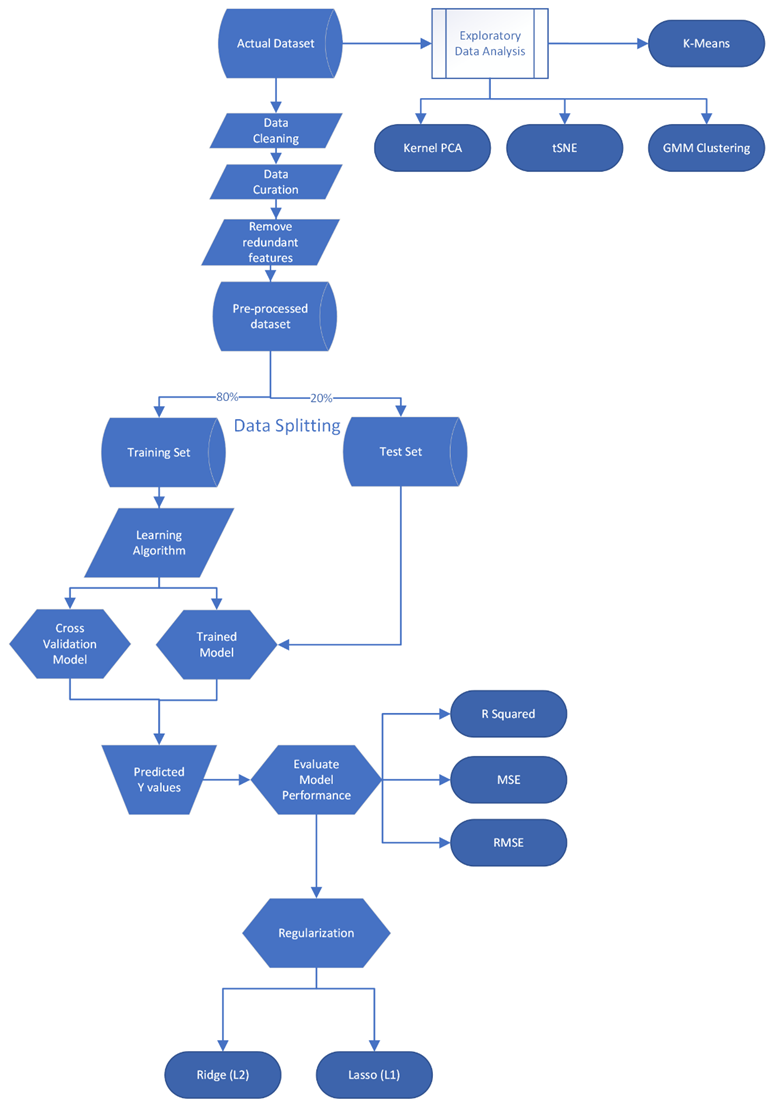

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler




In [ ]:
# Load the first few rows from the '1_1' sheet to explore its contents

url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1166194/2005-21-uk-local-authority-ghg-emissions.xlsx'
data_1_1 = pd.read_excel(url, sheet_name='1_1')

#data_1_1 = pd.read_excel("2005-21-uk-local-authority-ghg-emissions-update-060723.xlsx", sheet_name='1_1')
data_1_1.head()

In [ ]:
# Extract the actual data, excluding the header information
data_1_1_actual = data_1_1.iloc[4:]

# Set the column names from the header row
data_1_1_actual.columns = data_1_1.iloc[3]


# Reset the index for the actual data
data_1_1_actual = data_1_1_actual.reset_index(drop=True)

# Convert the 'Grand Total' column to a numeric type
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html
data_1_1_actual['Grand Total'] = pd.to_numeric(data_1_1_actual['Grand Total'], errors='coerce')

# Filter the data for the "West Midlands" Region/Country
west_midlands_data = data_1_1_actual[data_1_1_actual['Region/Country'] == 'West Midlands']

# Filter out rows where "Second Tier Authority" ends with "Total"
west_midlands_data_filtered = west_midlands_data[~west_midlands_data['Second Tier Authority'].str.endswith("Total")]

# List of columns to keep
columns_to_keep = ['Region/Country', 'Second Tier Authority', 'Local Authority', 'Local Authority Code', 'Calendar Year', 'LULUCF Net Emissions']

# Add columns that end with "Total"
columns_to_keep.extend([col for col in west_midlands_data_filtered.columns if col.endswith("Total")])
west_midlands_filtered_columns = west_midlands_data_filtered[columns_to_keep]

In [ ]:
# Create the pivot table of west_midlands local authorities emission
west_midlands_local_authority_emissions = pd.pivot_table(west_midlands_filtered_columns, values='Grand Total', index=['Local Authority'], columns=['Calendar Year'])

west_midlands_local_authority_emissions.to_csv('west_midlands_filtered_columns_by_year.csv')
west_midlands_local_authority_emissions

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the emissions data from a CSV file
emissions_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/west_midlands_filtered_columns_by_year.csv'
emissions_df = pd.read_csv(emissions_csv_path, index_col='Local Authority')

# Read the GeoDataFrame from a CSV file containing geometries
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)

# Convert the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))

# Set the figure size for the plots
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
axs = axs.flatten()

# Iterate over the range of years and create a plot for each
for idx, year in enumerate(range(2005, 2016)):
    # Select the column for the year
    year_column = str(year)
    westmidlands_emissions_df = emissions_df[[year_column]]

    # Merge the emissions data with the GeoDataFrame
    filtered_gdf = topo_lad_gdf.merge(westmidlands_emissions_df, left_on='LAD13NM', right_index=True)

    # Plot the merged data with "Emissions" as the color indicator
    ax = axs[idx]
    filtered_gdf.plot(ax=ax, column=year_column, cmap='viridis', legend=False, edgecolor='black')

    # Annotate each region with its name for clarity
    #for row_idx, row in filtered_gdf.iterrows():
    #    ax.annotate(text=row['LAD13NM'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
    #                xytext=(3, 3), textcoords='offset points', ha='center', fontsize=6)

    # Set the title for each subplot
    ax.set_title(f'Emissions in {year}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_aspect('equal')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Calculate the yearly total emissions for each year
yearly_totals = west_midlands_local_authority_emissions.sum()

# Append the totals as a new row to the DataFrame
west_midlands_local_authority_emissions.loc['Total'] = yearly_totals

west_midlands_local_authority_emissions

In [ ]:
import matplotlib.pyplot as plt

west_midlands_local_authority_emissions.loc['Total'] = yearly_totals

In [ ]:
# Plotting the trend over time
plt.figure(figsize=(12, 6))
yearly_totals.plot(marker='o', linestyle='-', color='black')
plt.title('Total WestMidlands Emissions Trend Over Time (2005-2021)')
plt.xlabel('Year')
plt.ylabel('Total Emissions (kt CO2e)')
plt.grid(True)
plt.show()
yearly_totals

In [ ]:
data_transposed = west_midlands_local_authority_emissions
data_transposed.to_csv('west_midlands_local_authority_emissions.csv')
data_transposed

In [ ]:
X = data_transposed.loc[:, 2005:2020]
y = data_transposed[2021]

In [ ]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10)


In [ ]:
# Train the model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Evaluate the model
print("Intercept:", regressor.intercept_)
print("Coefficients:", regressor.coef_)

# Predicting
y_pred = regressor.predict(X_test)

# Printing shapes of predictions and test labels
print(y_pred.shape, y_test.shape)

In [ ]:
X

In [ ]:
y

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

west_midlands_local_authority_emissions

X = west_midlands_local_authority_emissions.loc[:, 2005:2020]
y = west_midlands_local_authority_emissions[2021]

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10)

# Train the model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Evaluate the model
print("Intercept:", regressor.intercept_)
print("Coefficients:", regressor.coef_)

#predicting the test set result
y_pred = regressor.predict(X_test)
print(y_pred.shape,y_test.shape)
y_pred,y_test

<script type="text/javascript" src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"></script>


<p>Based on the output from the linear regression model, an approximate prediction equation for the emissions in 2021 is formed. The equation is structured as follows, where Xi represents the emissions in year 2005 + i (for i = 0, 1, 2, ..., 15):

Emissions_2021 = Intercept + c1 * X0 + c2 * X1 + ... + c16 * X15


<h1>Calibrating Regression</h1>

In [ ]:
pip install pycaret

In [ ]:

from pycaret.regression import *
regression_setup = setup(data=west_midlands_local_authority_emissions, target='2021', session_id=76)


In [ ]:
best_model = compare_models()


In [ ]:
from pycaret.regression import create_model
model = create_model('huber')

In [ ]:
tuned_model = tune_model(model)

In [ ]:
evaluate_model(tuned_model)

The comparative analysis of various regression models in this study reveals significant variability in their performance metrics, including Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), R-squared (R2), Root Mean Squared Logarithmic Error (RMSLE), Mean Absolute Percentage Error (MAPE), and computational time (TT in seconds).

The Huber Regressor emerges as the most efficient model with the lowest MAE (28.4215), MSE (2326.5486), and RMSE (34.3903), indicating its superior accuracy in predicting outcomes with minimal error. Its relatively low computational time (0.0650 seconds) further underscores its effectiveness in real-world applications where time efficiency is crucial.

Conversely, models such as the Dummy Regressor and Light Gradient Boosting Machine exhibit the highest errors across all metrics, rendering them the least effective for precise predictions in this context. Their dramatically high MAE, MSE, and RMSE values, coupled with significantly negative R2 scores, highlight their inadequacy for the task at hand.

Interestingly, advanced ensemble methods like the Random Forest Regressor and Extra Trees Regressor, despite their popularity in handling complex datasets, do not perform optimally in this analysis. This is evident from their relatively high error metrics and negligible to negative R2 values, suggesting a mismatch between their capabilities and the dataset's characteristics or the specific prediction task.

The study also sheds light on the computational efficiency of various models, with the Passive Aggressive Regressor standing out for its minimal processing time (0.0250 seconds). However, its higher error rates compared to the Huber Regressor suggest a trade-off between speed and accuracy.

In summary, the Huber Regressor's balance of precision and computational efficiency makes it the most suitable model for this dataset and prediction task. This analysis underscores the importance of model selection in data science, highlighting that the most complex or computationally intensive models are not always the most effective for every prediction scenario. Future research could delve deeper into the dataset's characteristics and the models' assumptions to further refine the choice of predictive modeling technique

<h1>GRU</h1>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [ ]:
#!cp "/content/drive/My Drive/Colab Notebooks/west_midlands_filtered_columns.csv" "west_midlands_filtered_columns.csv"

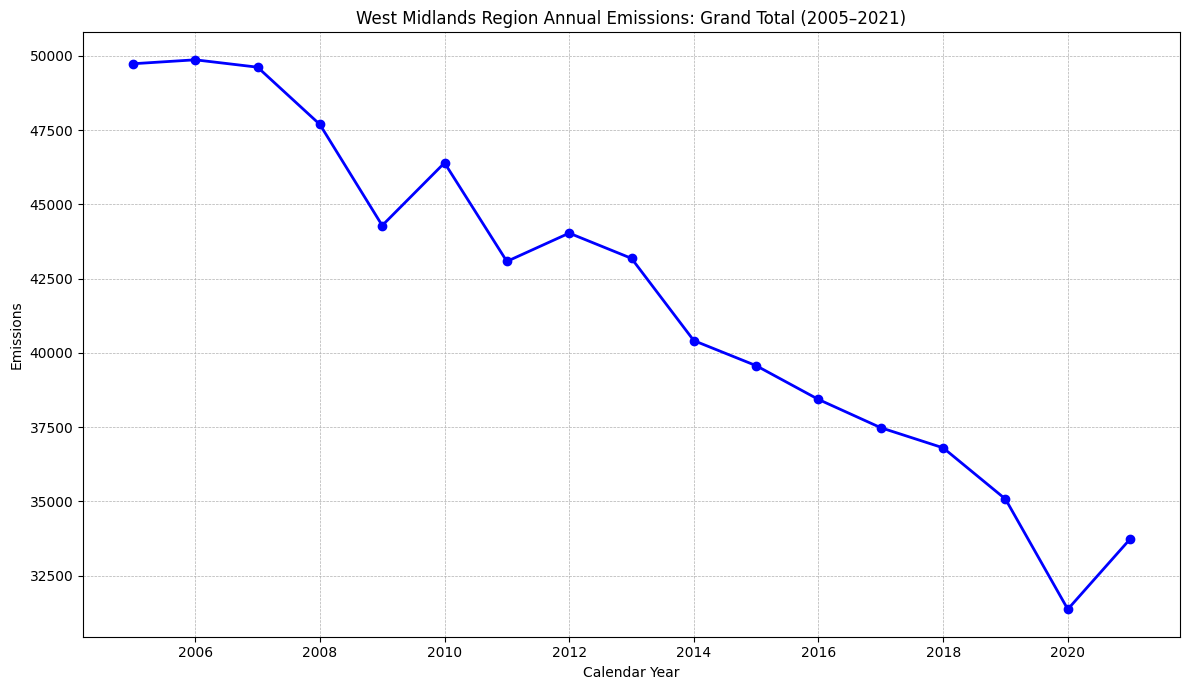

Calendar Year
2005    49732.222417
2006    49865.040184
2007    49616.825647
2008    47689.374420
2009    44287.997799
2010    46396.818960
2011    43080.033683
2012    44031.880064
2013    43181.893928
2014    40413.744458
2015    39570.616279
2016    38433.656517
2017    37482.255734
2018    36805.003905
2019    35080.103036
2020    31372.640144
2021    33736.855308
Name: Grand Total, dtype: float64

In [3]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/west_midlands_filtered_columns.csv')

#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/west_midlands_filtered_columns.csv')

#https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/west_midlands_filtered_columns.csv
# Group by 'Calendar Year' and sum the "Grand Total" values for each year
grouped_data = df.groupby('Calendar Year')['Grand Total'].sum()

# Plot the summed values for each year
plt.figure(figsize=(12, 7))
grouped_data.plot(kind='line', marker='o', color='blue', linewidth=2)

plt.title('West Midlands Region Annual Emissions: Grand Total (2005–2021)')
plt.ylabel('Emissions')
plt.xlabel('Calendar Year')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
grouped_data

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Modeling the time series data using a GRU. Proceeding with the following steps:

1. Data Preparation:
   - Normalize the data.
   - Transform the time series data into input-output pairs for supervised learning.
2. Define the GRU Model.
3. Compile and Train the Model.
4. Evaluate the Model.
5. Forecasting.

### Data Preparation

For this demonstration, a sliding window approach where the use of the emissions of the last \( N \) years to predict the emissions of the next year. Then setting \( N \) to 5.

Starting by normalizing the data and creating our input-output pairs.

The data has been prepared for training:

- Having 9 training samples and 3 testing samples.
- Each training sample has 1 time step and 5 features (i.e., the emissions of the last 5 years).
- The corresponding output is the emission of the next year.



### Define the GRU Model

A simple GRU-based model for this task. The model will consist of:

- An input layer that accepts sequences of 5 past observations.
- A GRU layer with 50 units.
- A dense output layer with a linear activation function to predict the next year's emissions.


In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Define a function to convert time series data into input-output pairs
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(grouped_data.values.reshape(-1, 1))

# Convert time series data into input-output pairs
N = 5  # number of past observations to use for prediction
data = series_to_supervised(scaled_data, n_in=N, n_out=1)
values = data.values

# Split the data into training and testing sets
train_size = int(0.8 * len(values))
train, test = values[:train_size, :], values[train_size:, :]
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

# Reshaping data to 3D [samples, timesteps, features] for GRU
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((9, 1, 5), (9,), (3, 1, 5), (3,))

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Define the GRU model
model = Sequential()
model.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Display the model's architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                8550      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 8601 (33.60 KB)
Trainable params: 8601 (33.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [7]:
# Predict on the test set
y_pred = model.predict(X_test)

1/1 [==============================] - 1s 568ms/step


In [8]:
# Inverse transform the predictions to the original scale
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

In [10]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f"Test RMSE: {rmse}")

Test RMSE: 3579.0355689182707


In [11]:
import matplotlib.pyplot as plt

# 1. Training and Validation Loss over Epochs
def plot_training_history(history):
    plt.figure(figsize=(12, 7))
    plt.plot(history.history['loss'], label='Training Loss', color='yellow', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='green', linestyle='--', linewidth=2)
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# 2. Actual vs. Predicted Emissions on the Test Set
def plot_actual_vs_predicted(y_test, y_pred):
    # Inverse transform the predictions and actual values to the original scale
    y_pred_original = scaler.inverse_transform(y_pred)
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(12, 7))
    plt.plot(y_test_original, marker='o', label='Actual', color='green', linewidth=2)
    plt.plot(y_pred_original, marker='x', label='Predicted', color='yellow', linestyle='dashed', linewidth=2)
    plt.title('GRU: Actual vs. Predicted Emissions')
    plt.ylabel('Emissions')
    plt.xlabel('Data Points')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

NameError: name 'history' is not defined

In [12]:
plot_actual_vs_predicted(y_test, y_pred)

NameError: name 'plot_actual_vs_predicted' is not defined

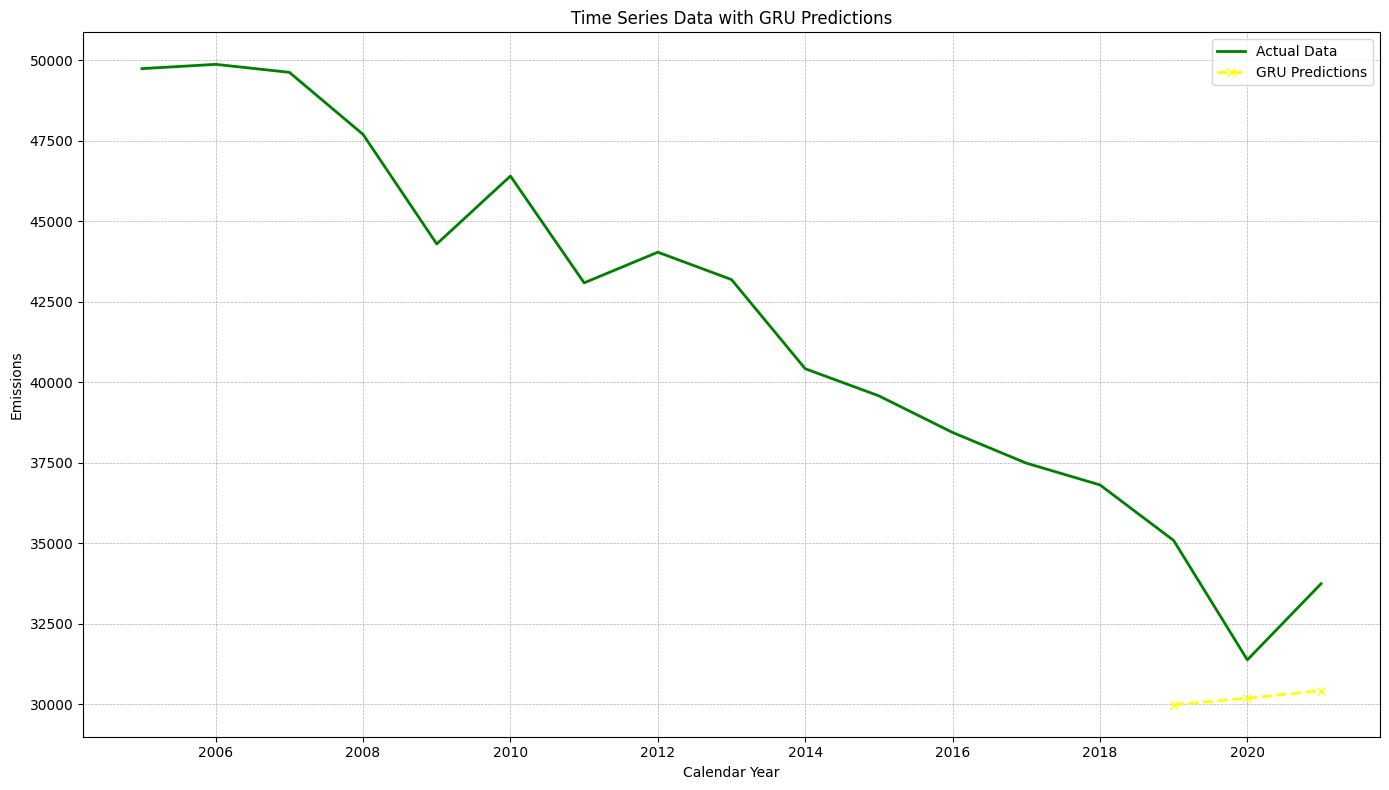

In [13]:
import matplotlib.pyplot as plt

def plot_full_series_with_predictions(data, y_test, y_pred, start_idx):
    """
    Plot the entire time series data and overlay the GRU predictions on the test set.

    Parameters:
    - data: The entire time series data.
    - y_test: True values for the test set.
    - y_pred: Predicted values from the model for the test set.
    - start_idx: The index in the data where the test set begins.
    """
    # Inverse transform the predictions and actual values to the original scale
    y_pred_original = scaler.inverse_transform(y_pred)
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(14, 8))

    # Plot the entire data
    plt.plot(data.index, data.values, label='Actual Data', color='green', linewidth=2)

    # Plot the predictions on top of the test set
    predicted_dates = data.index[start_idx:start_idx + len(y_pred)]
    plt.plot(predicted_dates, y_pred_original, marker='x', label='GRU Predictions', color='yellow', linestyle='dashed', linewidth=2)

    plt.title('Time Series Data with GRU Predictions')
    plt.ylabel('Emissions')
    plt.xlabel('Calendar Year')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

start_idx_of_test = len(grouped_data) - len(y_test)
plot_full_series_with_predictions(grouped_data, y_test, y_pred, start_idx_of_test)


<h1>GRU Calibration</h1>

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.3671 - val_loss: 0.0947
Epoch 2/50
1/1 [==============================] - 0s 36ms/step - loss: 0.3373 - val_loss: 0.0836
Epoch 3/50
1/1 [==============================] - 0s 33ms/step - loss: 0.3087 - val_loss: 0.0733
Epoch 4/50
1/1 [==============================] - 0s 32ms/step - loss: 0.2815 - val_loss: 0.0636
Epoch 5/50
1/1 [==============================] - 0s 34ms/step - loss: 0.2557 - val_loss: 0.0547
Epoch 6/50
1/1 [==============================] - 0s 35ms/step - loss: 0.2312 - val_loss: 0.0465
Epoch 7/50
1/1 [==============================] - 0s 35ms/step - loss: 0.2081 - val_loss: 0.0390
Epoch 8/50
1/1 [==============================] - 0s 37ms/step - loss: 0.1864 - val_loss: 0.0322
Epoch 9/50
1/1 [==============================] - 0s 34ms/step - loss: 0.1661 - val_loss: 0.0261
Epoch 10/50
1/1 [==============================] - 0s 33ms/step - loss: 0.1472 - val_loss: 0.0207
Epoch 11/50
1/1 [==============

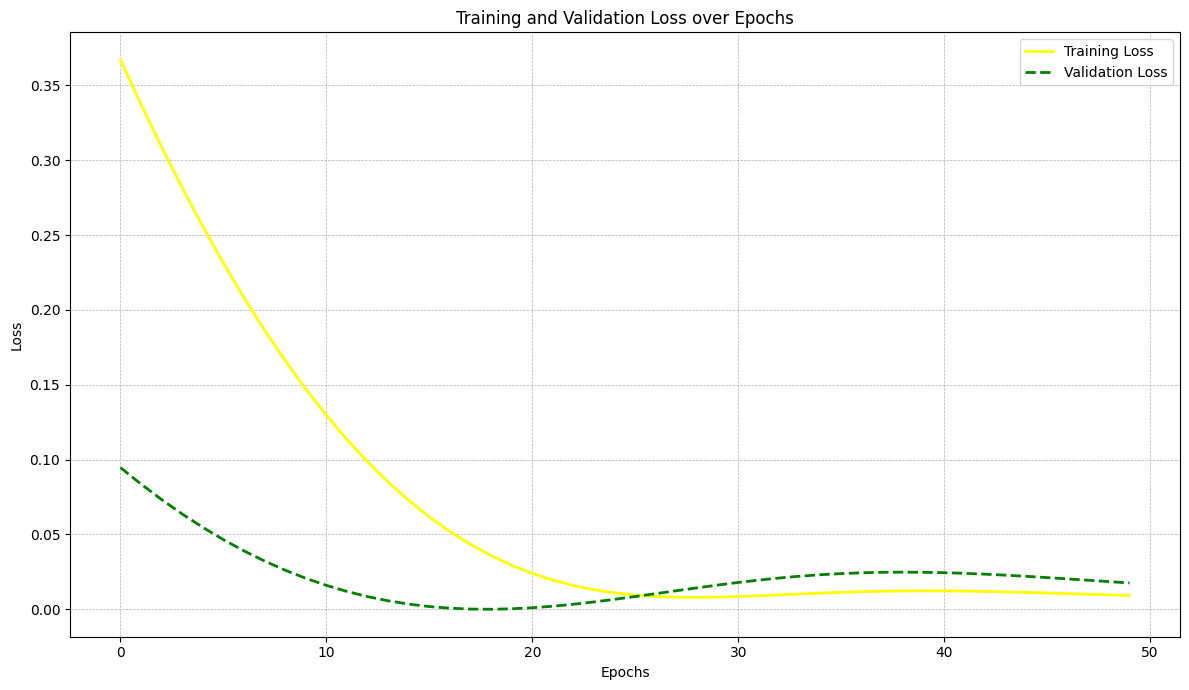

In [16]:
# Train the model and store the training history
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1)

# Plot the training history
def plot_training_history(history):
    plt.figure(figsize=(12, 7))
    plt.plot(history.history['loss'], label='Training Loss', color='yellow', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='green', linestyle='--', linewidth=2)
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [4]:
!pip install keras==2.15.0


In [3]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Define a function to create a GRU model
def create_gru_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(GRU(units=units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Create a KerasRegressor wrapper
model = KerasRegressor(build_fn=create_gru_model, verbose=0)

# Define the hyperparameters to search
param_grid = {
    'units': [50, 100, 150],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150]
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_result = grid_search.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [ ]:
#!cp "/content/drive/My Drive/Colab Notebooks/Dissertation_Code.ipynb" "Dissertation_Code.ipynb"


In [ ]:
#!cp "/content/drive/My Drive/Colab Notebooks/topo_eer.csv" "topo_eer.csv"

<H1>SPARTIAL ANALYSIS</H1>

In [68]:
import geopandas as gpd
import pandas as pd
#pip install geopandas
import json
from google.colab import drive
#drive.mount('/content/drive')
# Reading the TopoJSON file
#file_path = 'topo_eer.json'
#https://github.com/martinjc/UK-GeoJSON/blob/master/json/electoral/wal/topo_eer.json
#https://drive.google.com/file/d/1Y_lBZU_GUnl4qzN_sYaS8JzLpzEHMlwp/view?usp=sharing
#/content/drive/MyDrive/topo_eer.json
#topo_eer_gdf = gpd.read_file(file_path)



topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_eer.csv'
#/content/drive/MyDrive/Colab Notebooks/topo_eer.csv
#https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_eer.csv

topo_eer_gdf = pd.read_csv(topo_lad_csv_path)

# Displaying the first few rows to understand its structure
topo_eer_gdf

Unnamed: 0         id    EER13CD  EER13CDO                   EER13NM  \
0           0  E15000001  E15000001         1                North East   
1           1  E15000002  E15000002         2                North West   
2           2  E15000003  E15000003         3  Yorkshire and The Humber   
3           3  E15000004  E15000004         4             East Midlands   
4           4  E15000005  E15000005         5             West Midlands   
5           5  E15000006  E15000006         6                   Eastern   
6           6  E15000007  E15000007         7                    London   
7           7  E15000008  E15000008         8                South East   
8           8  E15000009  E15000009         9                South West   

                                            geometry  
0  MULTIPOLYGON (((-1.2252565022535702 54.6258513...  
1  MULTIPOLYGON (((-3.205370776233162 53.37164649...  
2  MULTIPOLYGON (((-0.5534904613704112 53.6904012...  
3  MULTIPOLYGON (((0.2688297226583032 52.81560973...  
4  POLYGON ((-1.8135631811756063 53.1325804218624...  
5  MULTIPOLYGON (((0.5404817635513712 51.51739773...  
6  MULTIPOLYGON (((-0.3211134143414016 51.4460347...  
7  MULTIPOLYGON (((-1.588550195496107 50.66282574...  
8  MULTIPOLYGON (((-6.398918714804379 49.86534415...

In [69]:
import geopandas as gpd

# Reading the TopoJSON file
#file_path = '/content/drive/MyDrive/Colab Notebooks/topo_eer.json'
file_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_eer.json'
topo_eer_gdf = gpd.read_file(file_path)

# Displaying the first few rows to understand its structure
topo_eer_gdf.head()
topo_eer_gdf.to_csv('topo_eer.csv')

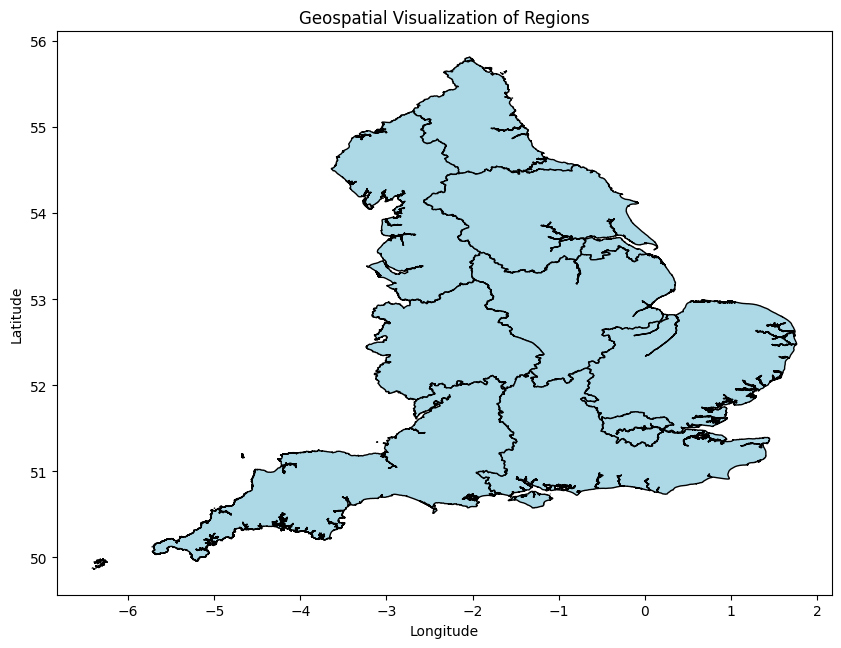

In [70]:
import matplotlib.pyplot as plt

# Replotting the GeoDataFrame with the necessary library imported
topo_eer_gdf.plot(figsize=(10, 10), edgecolor='black', facecolor='lightblue')

# Adding title and axes labels
plt.title('Geospatial Visualization of Regions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()


In [71]:
import pandas as pd

# Emissions data
emissions_data = {
    "Region/Country": ["East Midlands", "Eastern", "London", "North East", "North West",
                       "South East", "South West", "West Midlands", "Yorkshire and The Humber"],
    "Per Capita Emissions": [9.710848, 8.091197, 10.318067, 11.400630, 9.260969,
                             6.804080, 8.215306, 8.623030, 11.376461],
    "Emissions per km^2": [5.318442, 5.769531, 47.155219, 11.222972, 7.706417,
                           6.286119, 3.880700, 7.402992, 5.033133]
}

emissions_df = pd.DataFrame(emissions_data)

# Merging the emissions data with the geospatial data
merged_data = topo_eer_gdf.merge(emissions_df, left_on='EER13NM', right_on='Region/Country')

merged_data.head()  # Displaying the first few rows of the merged data for verification

id    EER13CD EER13CDO                   EER13NM  \
0  E15000001  E15000001       01                North East   
1  E15000002  E15000002       02                North West   
2  E15000003  E15000003       03  Yorkshire and The Humber   
3  E15000004  E15000004       04             East Midlands   
4  E15000005  E15000005       05             West Midlands   

                                            geometry  \
0  MULTIPOLYGON (((-1.22526 54.62585, -1.22444 54...   
1  MULTIPOLYGON (((-3.20537 53.37165, -3.20373 53...   
2  MULTIPOLYGON (((-0.55349 53.69040, -0.54613 53...   
3  MULTIPOLYGON (((0.26883 52.81561, 0.26392 52.8...   
4  POLYGON ((-1.81356 53.13258, -1.81356 53.13318...   

             Region/Country  Per Capita Emissions  Emissions per km^2  
0                North East             11.400630           11.222972  
1                North West              9.260969            7.706417  
2  Yorkshire and The Humber             11.376461            5.033133  
3             East Midlands              9.710848            5.318442  
4             West Midlands              8.623030            7.402992

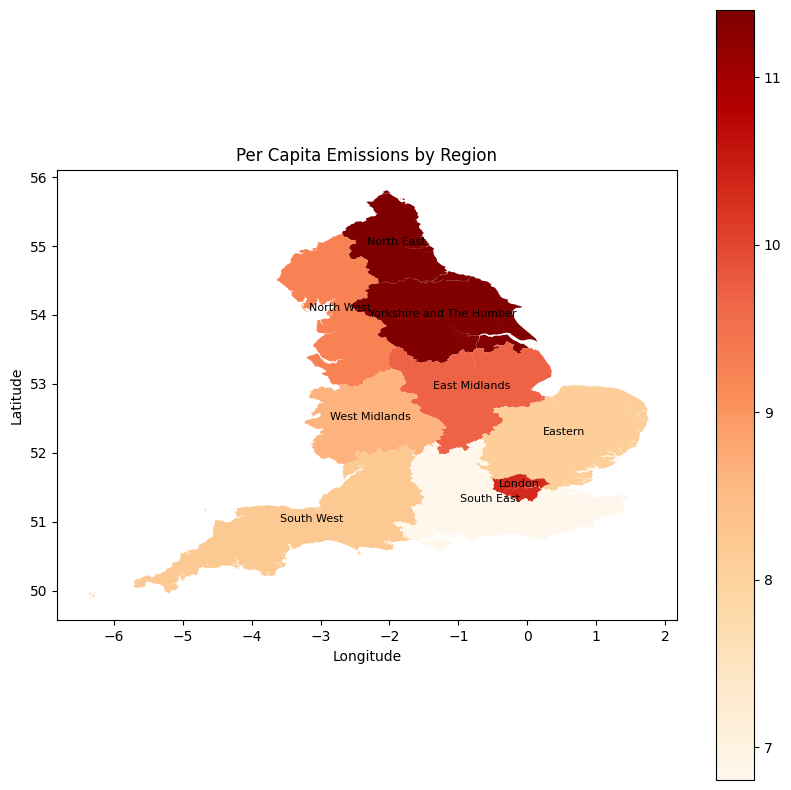

In [72]:
import matplotlib.pyplot as plt

# Plotting the merged data with "Per Capita Emissions" as the color indicator
ax = merged_data.plot(column='Per Capita Emissions', cmap='OrRd', legend=True, figsize=(10, 10))

# Annotating each region with its name for clarity
for idx, row in merged_data.iterrows():
    pos = row['geometry'].centroid.coords[0]
    ax.annotate(text=row['Region/Country'], xy=pos, horizontalalignment='center', fontsize=8)

# Setting the title and labels
plt.title('Per Capita Emissions by Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()


<h3>Per capita emissions refer to the average release of emissions (carbon dioxide, CO2) attributed to each individual within a certain population.<h3/>

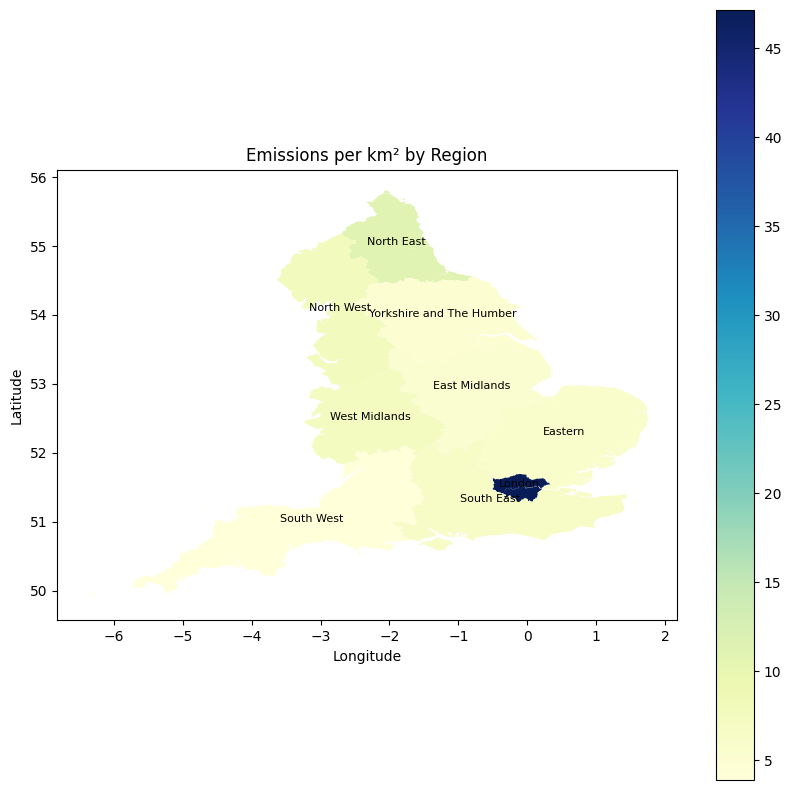

In [73]:
# Plotting the merged data with "Emissions per km^2" as the color indicator
ax = merged_data.plot(column='Emissions per km^2', cmap='YlGnBu', legend=True, figsize=(10, 10))

# Annotating each region with its name for clarity
for idx, row in merged_data.iterrows():
    pos = row['geometry'].centroid.coords[0]
    ax.annotate(text=row['Region/Country'], xy=pos, horizontalalignment='center', fontsize=8)

# Setting the title and labels
plt.title('Emissions per km² by Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()

<h3>
The term "Average Emissions per km² by Region" refers to a measure used to understand the density of emissions in a given area. This metric provides an average value of emissions (carbon dioxide, CO2) distributed over the total land area of a region, expressed in square kilometers (km²)<h3/>

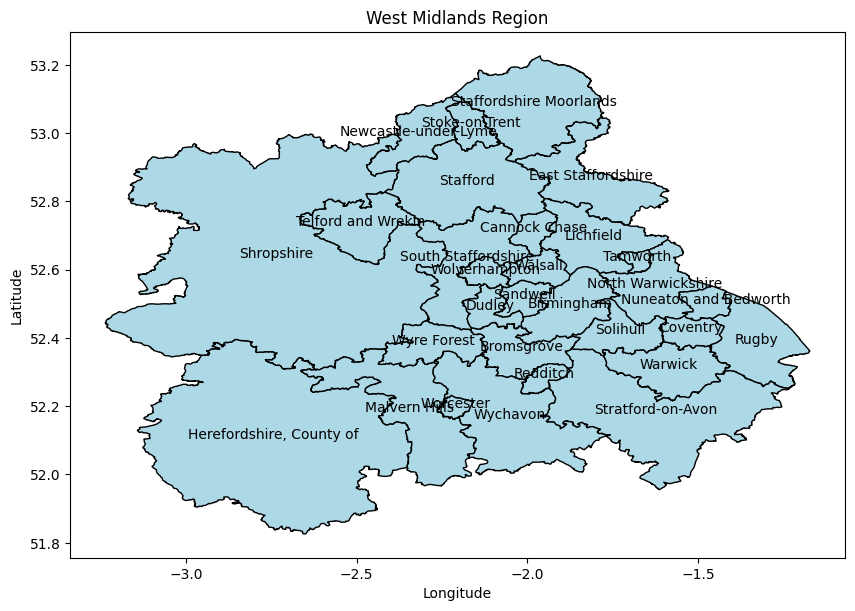

In [74]:
# Reading the CSV file into a DataFrame
#topo_lad_csv_path = '/content/drive/MyDrive/Colab Notebooks/topo_lad_1.csv'
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
#https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv

topo_lad_df = pd.read_csv('https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv')

#file_path = 'topo_lad.json'
#topo_lad_df = gpd.read_file(file_path)

# Converting the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))

# Filtering for the specified areas
areas_to_visualize = [
    "Birmingham", "Bromsgrove", "Cannock Chase", "Coventry", "Dudley",
    "East Staffordshire", "Herefordshire, County of", "Lichfield", "Malvern Hills",
    "Newcastle-under-Lyme", "North Warwickshire", "Nuneaton and Bedworth", "Redditch",
    "Rugby", "Sandwell", "Shropshire", "Solihull", "South Staffordshire",
    "Stafford", "Staffordshire Moorlands", "Stoke-on-Trent", "Stratford-on-Avon",
    "Tamworth", "Telford and Wrekin", "Walsall", "Warwick", "Wolverhampton",
    "Worcester", "Wychavon", "Wyre Forest"
]

# Filtering the GeoDataFrame for the Westmidlands areas
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize)]

# Plotting the "West Midlands" region
ax = filtered_gdf.plot(figsize=(10, 10), edgecolor='black', facecolor='lightblue')

# Annotating the region with its name
for idx, row in filtered_gdf.iterrows():
    pos = row['geometry'].centroid.coords[0]
    ax.annotate(text=row['LAD13NM'], xy=pos, horizontalalignment='center')

# Setting the title and labels
plt.title('West Midlands Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()

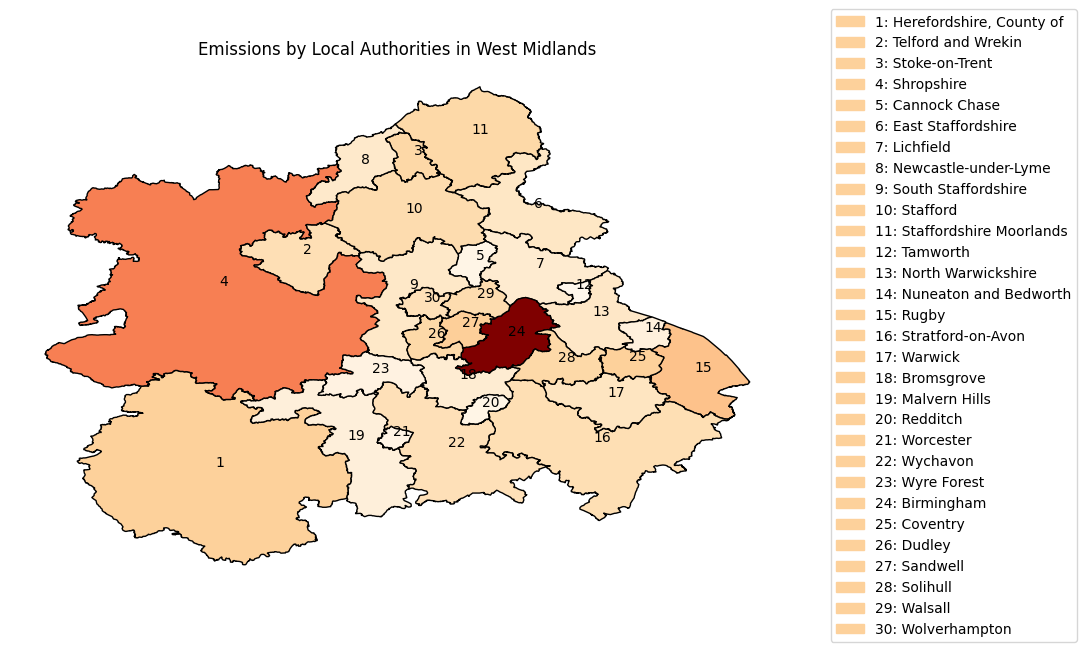

In [75]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


# Reading the CSV file into a DataFrame
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)

# Converting the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))

areas_to_visualize = {
    "Local Authority": [
        "Birmingham", "Bromsgrove", "Cannock Chase", "Coventry", "Dudley",
        "East Staffordshire", "Herefordshire, County of", "Lichfield", "Malvern Hills",
        "Newcastle-under-Lyme", "North Warwickshire", "Nuneaton and Bedworth", "Redditch",
        "Rugby", "Sandwell", "Shropshire", "Solihull", "South Staffordshire",
        "Stafford", "Staffordshire Moorlands", "Stoke-on-Trent", "Stratford-on-Avon",
        "Tamworth", "Telford and Wrekin", "Walsall", "Warwick", "Wolverhampton",
        "Worcester", "Wychavon", "Wyre Forest"
    ],
    "Emissions": [
        96194.42, 14592.43, 8323.91, 29913.27, 26291.81,
        18530.12, 30369.14, 15314.26, 12044.33,
        16825.96, 18244.97, 11604.42, 8275.61,
        37092.39, 31099.31, 55209.7, 26119.39, 17940.00,
        24410.05, 26321.27, 26681.51, 23179.05,
        6411.41, 22889.89, 24428.08, 19614.43, 22070.84,
        8733.09, 22128.51, 9923.38
    ]
}

westmidlands_emissions_df = pd.DataFrame(areas_to_visualize)

# Filtering the GeoDataFrame for the specified areas
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize["Local Authority"])]

# Merging the emissions data with the geospatial data
filtered_gdf = filtered_gdf.merge(westmidlands_emissions_df, left_on='LAD13NM', right_on='Local Authority')

filtered_gdf['ID'] = range(1, len(filtered_gdf) + 1)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#filtered_gdf.plot(ax=ax, color='white', edgecolor='black')
filtered_gdf.plot(ax=ax, column='Emissions', cmap='OrRd', legend=False, edgecolor='black')

#filtered_gdf.plot(column='Emissions', cmap='OrRd', legend=True)


for idx, row in filtered_gdf.iterrows():
    plt.annotate(text=row['ID'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
             xytext=(5, 5), textcoords='offset points',
             horizontalalignment='center', verticalalignment='center')

from matplotlib.patches import Patch
legend_labels = [Patch(label=f'{row["ID"]}: {row["LAD13NM"]}', color = '#FDD19B') for idx, row in filtered_gdf.iterrows()]

plt.legend(handles=legend_labels, bbox_to_anchor=(1.05, 0.5), loc='center left')

# Setting the title and labels
plt.title('Emissions by Local Authorities in West Midlands')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


ax.axis('off')
# Displaying the plot
plt.show()





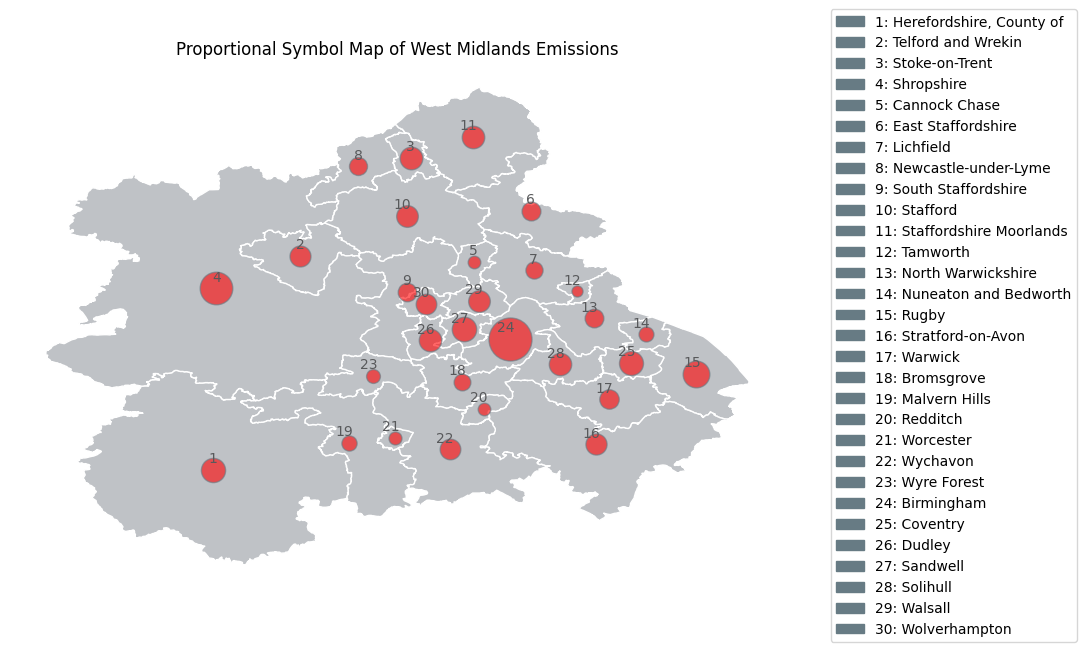

In [76]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)

topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))

areas_to_visualize = {
    "Local Authority": [
        "Birmingham", "Bromsgrove", "Cannock Chase", "Coventry", "Dudley",
        "East Staffordshire", "Herefordshire, County of", "Lichfield", "Malvern Hills",
        "Newcastle-under-Lyme", "North Warwickshire", "Nuneaton and Bedworth", "Redditch",
        "Rugby", "Sandwell", "Shropshire", "Solihull", "South Staffordshire",
        "Stafford", "Staffordshire Moorlands", "Stoke-on-Trent", "Stratford-on-Avon",
        "Tamworth", "Telford and Wrekin", "Walsall", "Warwick", "Wolverhampton",
        "Worcester", "Wychavon", "Wyre Forest"
    ],
    "Emissions": [
        96194.42, 14592.43, 8323.91, 29913.27, 26291.81,
        18530.12, 30369.14, 15314.26, 12044.33,
        16825.96, 18244.97, 11604.42, 8275.61,
        37092.39, 31099.31, 55209.7, 26119.39, 17940.00,
        24410.05, 26321.27, 26681.51, 23179.05,
        6411.41, 22889.89, 24428.08, 19614.43, 22070.84,
        8733.09, 22128.51, 9923.38
    ]
}

West_Midlands_emissions_df = pd.DataFrame(areas_to_visualize)

filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize["Local Authority"])]
filtered_gdf = filtered_gdf.merge(West_Midlands_emissions_df, left_on='LAD13NM', right_on='Local Authority')

filtered_gdf['ID'] = range(1, len(filtered_gdf) + 1)

fig, ax = plt.subplots(figsize=(10, 10))
filtered_gdf.plot(ax=ax, color='#BFC2C6', edgecolor='white')

filtered_gdf['centroid'] = filtered_gdf.geometry.centroid

for idx, row in filtered_gdf.iterrows():
    ax.scatter(row['centroid'].x, row['centroid'].y, s=row['Emissions'] / 100, edgecolor='#677B84', color='red', alpha=0.6)

if 'ID' in filtered_gdf.columns:
    for idx, row in filtered_gdf.iterrows():
        plt.annotate(text=row['ID'], xy=(row['centroid'].x, row['centroid'].y),
                     xytext=(3, 3), textcoords="offset points", color='#58595B',
                     horizontalalignment='right', verticalalignment='bottom')

from matplotlib.patches import Patch
legend_labels = [Patch(label=f'{row["ID"]}: {row["LAD13NM"]}', color = '#677B84') for idx, row in filtered_gdf.iterrows()]

plt.legend(handles=legend_labels, bbox_to_anchor=(1.05, 0.5), loc='center left')

ax.set_title('Proportional Symbol Map of West Midlands Emissions')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ax.axis('off')
plt.show()


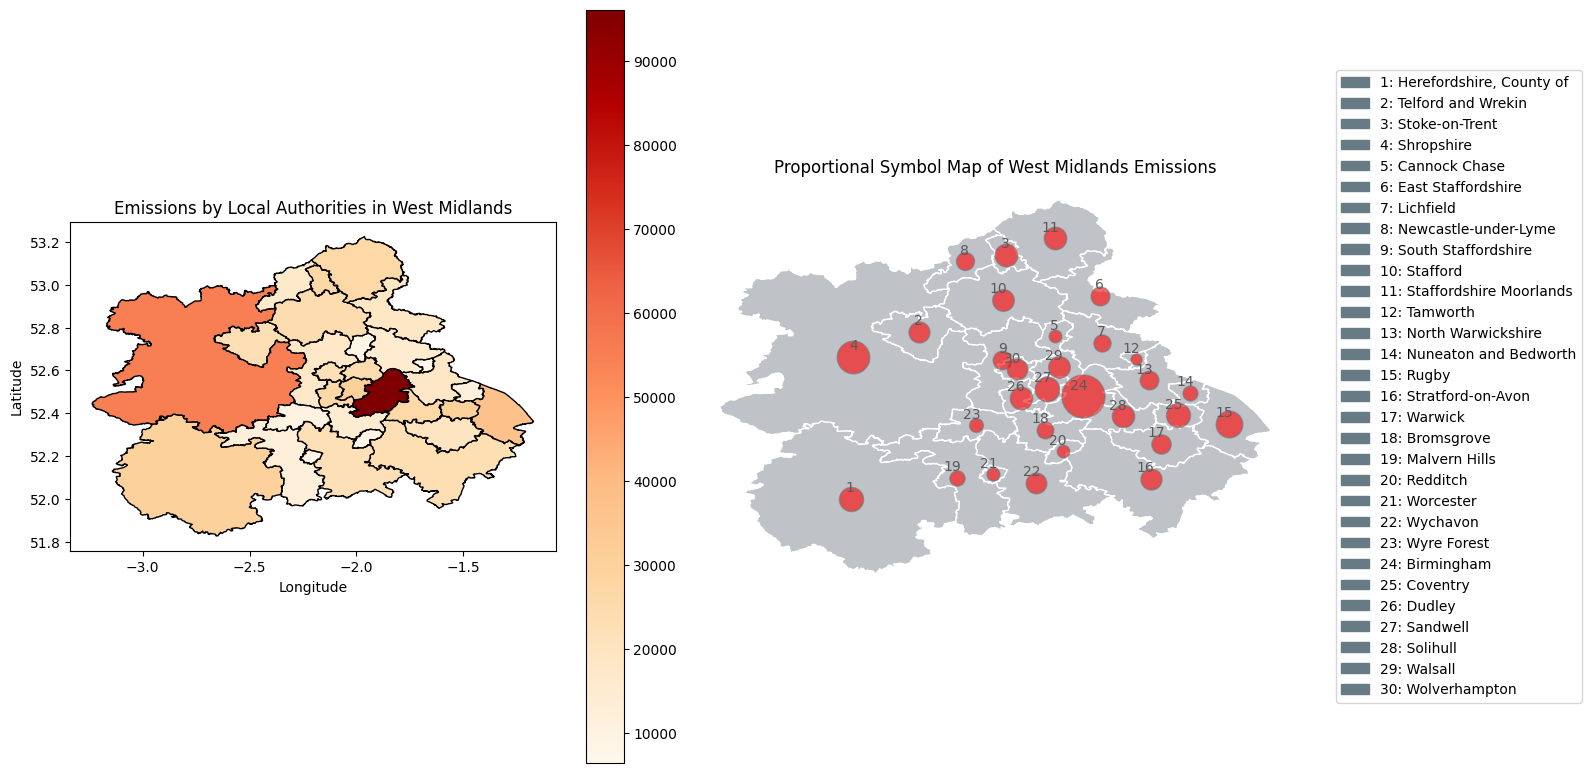

In [77]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(16, 8))



# Plotting the first map: Choropleth Map
# Reading and preparing the data
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize["Local Authority"])]
filtered_gdf = filtered_gdf.merge(West_Midlands_emissions_df, left_on='LAD13NM', right_on='Local Authority')
filtered_gdf['ID'] = range(1, len(filtered_gdf) + 1)

# Plotting the map
filtered_gdf.plot(column='Emissions', cmap='OrRd', legend=True, ax=axes[0], edgecolor='black')
axes[0].set_title('Emissions by Local Authorities in West Midlands')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Plotting the second map: Proportional Symbol Map
# Plotting the map
filtered_gdf.plot(ax=axes[1], color='#BFC2C6', edgecolor='white')

filtered_gdf['centroid'] = filtered_gdf.geometry.centroid
for idx, row in filtered_gdf.iterrows():
    axes[1].scatter(row['centroid'].x, row['centroid'].y, s=row['Emissions'] / 100, edgecolor='#677B84', color='red', alpha=0.6)
    axes[1].annotate(text=row['ID'], xy=(row['centroid'].x, row['centroid'].y),
                     xytext=(3, 3), textcoords="offset points", color='#58595B',
                     horizontalalignment='right', verticalalignment='bottom')

# Setting titles and labels for the second map
axes[1].set_title('Proportional Symbol Map of West Midlands Emissions')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

# Remove axis for the second map
axes[1].axis('off')

# Legend for the proportional symbol map
legend_labels = [Patch(label=f'{row["ID"]}: {row["LAD13NM"]}', color='#677B84') for idx, row in filtered_gdf.iterrows()]
axes[1].legend(handles=legend_labels, bbox_to_anchor=(1.05, 0.5), loc='center left')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plotting the merged data with "Per Capita Emissions" as the color indicator
ax = merged_data.plot(column='Per Capita Emissions', cmap='OrRd', legend=True, figsize=(8, 6))

# Annotating each region with its name for clarity
for idx, row in merged_data.iterrows():
    pos = row['geometry'].centroid.coords[0]
    ax.annotate(text=row['Region/Country'], xy=pos, horizontalalignment='center', fontsize=8)

# Setting the title and labels
plt.title('Per Capita Emissions by Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Accessing the legend and setting its orientation to horizontal
legend = ax.get_legend()
legend.set_bbox_to_anchor((1.05, 1))  # Adjust position of legend
legend.set_orientation('horizontal')  # Set legend orientation to horizontal

# Displaying the plot
plt.tight_layout()  # Adjust layout to fit plot within document constraints
plt.savefig('per_capita_emissions.png', dpi=300)  # Save plot to file
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plotting the merged data with "Emissions per km^2" as the color indicator
ax = merged_data.plot(column='Emissions per km^2', cmap='YlGnBu', legend=True, figsize=(8, 6))

# Annotating each region with its name for clarity
for idx, row in merged_data.iterrows():
    pos = row['geometry'].centroid.coords[0]
    ax.annotate(text=row['Region/Country'], xy=pos, horizontalalignment='center', fontsize=8)

# Setting the title and labels
plt.title('Emissions per km² by Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Accessing the legend and setting its orientation to horizontal
legend = ax.get_legend()
legend.set_bbox_to_anchor((1.05, 1))  # Adjust position of legend
legend.set_orientation('horizontal')  # Set legend orientation to horizontal

# Displaying the plot
plt.tight_layout()  # Adjust layout to fit plot within document constraints
plt.savefig('emissions_per_km2.png', dpi=300)  # Save plot to file
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting the merged data with "Emissions per km^2" as the color indicator
merged_data.plot(column='Emissions per km^2', cmap='YlGnBu', legend=True, ax=axes[0])

# Annotating each region with its name for clarity
for idx, row in merged_data.iterrows():
    pos = row['geometry'].centroid.coords[0]
    axes[0].annotate(text=row['Region/Country'], xy=pos, horizontalalignment='center', fontsize=8)

# Setting the title and labels for the first plot
axes[0].set_title('Emissions per km² by Region')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Plotting the merged data with "Per Capita Emissions" as the color indicator
merged_data.plot(column='Per Capita Emissions', cmap='OrRd', legend=True, ax=axes[1])

# Annotating each region with its name for clarity
for idx, row in merged_data.iterrows():
    pos = row['geometry'].centroid.coords[0]
    axes[1].annotate(text=row['Region/Country'], xy=pos, horizontalalignment='center', fontsize=8)

# Setting the title and labels for the second plot
axes[1].set_title('Per Capita Emissions by Region')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

# Adjust layout to fit plot within document constraints
plt.tight_layout()

# Save plots to file
plt.savefig('emissions_comparison.png', dpi=300)



# Displaying the plots
plt.show()


<h1>London</h1>

In [ ]:
import geopandas as gpd
#pip install geopandas
import pandas as pd
import matplotlib.pyplot as plt

# Reading the CSV file into a DataFrame
#topo_lad_csv_path = '/content/drive/MyDrive/Colab Notebooks/topo_lad_1.csv'
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
#https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv
topo_lad_df = pd.read_csv(topo_lad_csv_path)

# Converting the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))


areas_to_visualize = {
    "Local Authority": [
        "Barking and Dagenham", "Barnet", "Bexley", "Brent", "Bromley",
        "Camden", "City of London", "Croydon", "Ealing", "Enfield",
        "Greenwich", "Hackney", "Hammersmith and Fulham", "Haringey", "Harrow",
        "Havering", "Hillingdon", "Hounslow", "Islington", "Kensington and Chelsea",
        "Kingston upon Thames", "Lambeth", "Lewisham", "Merton", "Newham",
        "Redbridge", "Richmond upon Thames", "Southwark", "Sutton", "Tower Hamlets",
        "Waltham Forest", "Wandsworth", "Westminster"
    ],
    "Emissions": [
        15463.91025, 28691.27869, 18692.49984, 24094.3711, 23449.86935,
        25153.52172, 21824.12753, 25312.44843, 26508.9953, 25266.11173,
        19444.03101, 14131.06025, 15768.98906, 15256.69209, 14873.18658,
        21802.04362, 35004.48549, 24510.70171, 17262.92168, 19815.56886,
        12900.68594, 21174.76154, 17832.82757, 14467.75162, 24878.6207,
        17747.91536, 14933.43661, 25433.82893, 13510.13559, 31954.69088,
        15380.36485, 20286.94346, 47718.18393
    ]
}

London_emissions_df = pd.DataFrame(areas_to_visualize)

# Filtering the GeoDataFrame for the specified areas
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize["Local Authority"])]

# Merging the emissions data with the geospatial data
filtered_gdf = filtered_gdf.merge(London_emissions_df, left_on='LAD13NM', right_on='Local Authority')

filtered_gdf['ID'] = range(1, len(filtered_gdf) + 1)


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#filtered_gdf.plot(ax=ax, color='white', edgecolor='black')
filtered_gdf.plot(ax=ax, column='Emissions', cmap='OrRd', legend=False, edgecolor='black')


for idx, row in filtered_gdf.iterrows():
    plt.annotate(text=row['ID'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
             xytext=(5, 5), textcoords='offset points',
             horizontalalignment='center', verticalalignment='center')

from matplotlib.patches import Patch
legend_labels = [Patch(label=f'{row["ID"]}: {row["LAD13NM"]}', color = '#FDD19B') for idx, row in filtered_gdf.iterrows()]

plt.legend(handles=legend_labels, bbox_to_anchor=(1.05, 0.5), loc='center left')


# Setting the title and labels
plt.title('Emissions by Local Authorities in London')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

ax.grid(False)

# Displaying the plot
plt.show()


<h1>North East</h1>

In [ ]:
# Filter the data for the "North East" Region/Country
North_East_data = data_1_1_actual[data_1_1_actual['Region/Country'] == 'North East']
North_East_data

In [ ]:
# Filter out rows where "Second Tier Authority" ends with "Total"
North_East_data_filtered = North_East_data[~North_East_data['Second Tier Authority'].str.endswith("Total")]

In [ ]:
North_East_data_filtered

In [ ]:
# Pivot table creation
pivot_table = pd.pivot_table(
    North_East_data_filtered,
    values=[
        'Commercial Total', 'Waste Management Total', 'Agriculture Total',
        'Transport Total', 'Domestic Total', 'Public Sector Total',
        'Industry Total', 'LULUCF Net Emissions','Emissions per km2 (kt CO2e)'
    ],
    index=['Calendar Year'],
    aggfunc=sum
)

# Transpose the pivot table to have categories as rows and years as columns
pivot_table_transposed = pivot_table.T

In [ ]:
pivot_table

In [ ]:
pivot_table_transposed

In [ ]:
pivot_table_transposed.corr()

In [ ]:
pivot_table.corr()

In [ ]:
# Generate the correlation matrix
corr = pivot_table.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Add title
plt.title('North East Correlation Matrix Heatmap')

# Show the plot
plt.show()


Values close to 1 indicate a strong positive correlation, meaning that as one feature increases, the other tends to increase as well.

Values close to -1 indicate a strong negative correlation, meaning that as one feature increases, the other tends to decrease.

Values close to 0 indicate little to no linear relationship between the features.

In [ ]:
# List of columns to keep
columns_to_keep = ['Region/Country', 'Second Tier Authority', 'Local Authority', 'Local Authority Code', 'Calendar Year', 'LULUCF Net Emissions']
# Add columns that end with "Total"
columns_to_keep.extend([col for col in North_East_data_filtered.columns if col.endswith("Total")])

In [ ]:
North_East_filtered_columns = North_East_data_filtered[columns_to_keep]

North_East_filtered_columns.to_csv('North_East_filtered_columns.csv')
North_East_filtered_columns

In [ ]:
North_East_filtered_columns.dtypes

In [ ]:
# Create the pivot table of west_midlands local authorities emission
North_East_local_authority_emissions = pd.pivot_table(North_East_filtered_columns, values='Grand Total', index=['Local Authority'], columns=['Calendar Year'])

North_East_local_authority_emissions.to_csv('North_East_filtered_columns_by_year.csv')
North_East_local_authority_emissions


In [ ]:
import pandas as pd
# Reading the CSV file into a DataFrame
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)

# Converting the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))


areas_to_visualize = {
    "Local Authority": ["County Durham", "Darlington", "Gateshead", "Hartlepool", "Middlesbrough",
                       "Newcastle upon Tyne", "North Tyneside", "Northumberland", "Redcar and Cleveland", "South Tyneside", "Stockton-on-Tees", "Sunderland"],
    "Emissions": [64421.44194, 12882.61833, 23387.99439, 14409.77169, 15161.56147,
                             29072.96486, 19330.82575, 60350.31757, 105582.7908, 12018.93366, 65626.36262, 29064.28939]
}


North_East_emissions_df = pd.DataFrame(areas_to_visualize)

# Filtering the GeoDataFrame for the specified areas
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize["Local Authority"])]


# Merging the emissions data with the geospatial data
filtered_gdf = filtered_gdf.merge(North_East_emissions_df, left_on='LAD13NM', right_on='Local Authority')


filtered_gdf['ID'] = range(1, len(filtered_gdf) + 1)


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#filtered_gdf.plot(ax=ax, color='white', edgecolor='black')
filtered_gdf.plot(ax=ax, column='Emissions', cmap='OrRd', legend=False, edgecolor='white')


for idx, row in filtered_gdf.iterrows():
    plt.annotate(text=row['ID'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
             xytext=(5, 5), textcoords='offset points',
             horizontalalignment='center', verticalalignment='center')

from matplotlib.patches import Patch
legend_labels = [Patch(label=f'{row["ID"]}: {row["LAD13NM"]}') for idx, row in filtered_gdf.iterrows()]

plt.legend(handles=legend_labels, bbox_to_anchor=(1.05, 0.5), loc='center left')


# Setting the title and labels
plt.title('Emissions by Local Authorities in North East')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Displaying the plot
plt.show()




In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Reading the CSV file into a DataFrame
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)

# Converting the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))

# Filtering for the specified areas
areas_to_visualize = [
    "Birmingham", "Bromsgrove", "Cannock Chase", "Coventry", "Dudley",
    "East Staffordshire", "Herefordshire, County of", "Lichfield", "Malvern Hills",
    "Newcastle-under-Lyme", "North Warwickshire", "Nuneaton and Bedworth", "Redditch",
    "Rugby", "Sandwell", "Shropshire", "Solihull", "South Staffordshire",
    "Stafford", "Staffordshire Moorlands", "Stoke-on-Trent", "Stratford-on-Avon",
    "Tamworth", "Telford and Wrekin", "Walsall", "Warwick", "Wolverhampton",
    "Worcester", "Wychavon", "Wyre Forest"
]

# Filtering the GeoDataFrame for the specified areas
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize)]

# Assigning a unique color to each area
colors = plt.cm.get_cmap('hsv', len(areas_to_visualize))

# Plotting each area with a unique color and annotating with a number
fig, ax = plt.subplots(figsize=(10, 10))
legend_elements = []
for i, area in enumerate(areas_to_visualize):
    area_gdf = filtered_gdf[filtered_gdf['LAD13NM'] == area]
    area_gdf.plot(ax=ax, edgecolor='black', facecolor=colors(i))
    pos = area_gdf.geometry.centroid.iloc[0].coords[0]
    ax.annotate(text=str(i+1), xy=pos, horizontalalignment='center', verticalalignment='center', fontsize=8, weight='bold', color='white')
    legend_elements.append(Patch(facecolor=colors(i), edgecolor='black', label=f'{i+1}: {area}'))

# Setting the title and labels
ax.set_title('West Midlands Region')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Creating the legend outside the plot on the left
plt.legend(handles=legend_elements, title="Areas", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Reading the CSV file into a DataFrame
topo_lad_csv_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv'
topo_lad_df = pd.read_csv(topo_lad_csv_path)

# Converting the DataFrame to a GeoDataFrame
topo_lad_gdf = gpd.GeoDataFrame(topo_lad_df, geometry=gpd.GeoSeries.from_wkt(topo_lad_df['geometry']))

# Filtering for the specified areas
areas_to_visualize = [
        "Barking and Dagenham", "Barnet", "Bexley", "Brent", "Bromley",
        "Camden", "City of London", "Croydon", "Ealing", "Enfield",
        "Greenwich", "Hackney", "Hammersmith and Fulham", "Haringey", "Harrow",
        "Havering", "Hillingdon", "Hounslow", "Islington", "Kensington and Chelsea",
        "Kingston upon Thames", "Lambeth", "Lewisham", "Merton", "Newham",
        "Redbridge", "Richmond upon Thames", "Southwark", "Sutton", "Tower Hamlets",
        "Waltham Forest", "Wandsworth", "Westminster"
    ]

# Filtering the GeoDataFrame for the specified areas
filtered_gdf = topo_lad_gdf[topo_lad_gdf['LAD13NM'].isin(areas_to_visualize)]

# Assigning a unique color to each area
colors = plt.cm.get_cmap('hsv', len(areas_to_visualize))

# Plotting each area with a unique color and annotating with a number
fig, ax = plt.subplots(figsize=(10, 10))
legend_elements = []
for i, area in enumerate(areas_to_visualize):
    area_gdf = filtered_gdf[filtered_gdf['LAD13NM'] == area]
    area_gdf.plot(ax=ax, edgecolor='black', facecolor=colors(i))
    pos = area_gdf.geometry.centroid.iloc[0].coords[0]
    ax.annotate(text=str(i+1), xy=pos, horizontalalignment='center', verticalalignment='center', fontsize=8, weight='bold', color='white')
    legend_elements.append(Patch(facecolor=colors(i), edgecolor='black', label=f'{i+1}: {area}'))

# Setting the title and labels
ax.set_title('London')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Creating the legend outside the plot on the left
plt.legend(handles=legend_elements, title="Areas", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

file_path = 'https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/uk_regions.geojson'

uk_regions_gdf = gpd.read_file(file_path)

emissions_data = {
    "Region/Country": [
        "East Midlands", "East of England", "London", "North East", "North West",
        "Northern Ireland", "Scotland", "South East", "South West", "Wales",
        "West Midlands", "Yorkshire and the Humber"
    ],
    "Grand Total": [
        1.246579e+06, 1.518514e+06, 7.105470e+05, 4.513099e+05, 1.419484e+06,
        3.910081e+05, 8.602071e+05, 1.713013e+06, 1.073928e+06, 6.104329e+05,
        1.030287e+06, 9.443414e+05
    ]
}

#emissions_df = regional_emissions.reset_index()
#emissions_df.columns = ['Region/Country', 'Grand Total']

emissions_df = pd.DataFrame(emissions_data)
emissions_df['Region/Country'] = emissions_df['Region/Country'].replace({'East of England': 'East'})

uk_regions_with_emissions = uk_regions_gdf.merge(emissions_df, left_on='rgn19nm', right_on='Region/Country', how='left')

uk_regions_with_emissions['Number'] = range(1, len(uk_regions_with_emissions) + 1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
uk_regions_with_emissions.plot(column='Grand Total', ax=ax, cmap='RdYlGn_r', edgecolor='#58595B')

cmap = plt.cm.RdYlGn_r
norm = mcolors.Normalize(vmin=uk_regions_with_emissions['Grand Total'].min(), vmax=uk_regions_with_emissions['Grand Total'].max())

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.036, pad=0.04)
cbar.set_label('Total Emissions by Region(Kt CO2e)')

for idx, row in uk_regions_with_emissions.iterrows():
    plt.annotate(text=str(row['Number']), xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontweight='bold', color='black', fontsize=8)

legend_elements = [Patch(facecolor=plt.cm.RdYlGn_r(emission / uk_regions_with_emissions['Grand Total'].max()), edgecolor='black',
                         label=f"{number} - {region}") for number, region, emission in zip(uk_regions_with_emissions['Number'],
                         uk_regions_with_emissions['rgn19nm'], uk_regions_with_emissions['Grand Total'])]

ax.legend(handles=legend_elements, title="Regions", bbox_to_anchor=(1.55, 0.75), loc='upper left')

ax.set_title('UK Regional territorial greenhouse gas emissions estimates 2005-2021(Kt CO2e)', loc='left', position=(-0.3, 1))
plt.axis('off')
plt.show()


<h1>Network Science</h1>

In [ ]:
pip install --upgrade networkx matplotlib

In [ ]:
import pandas as pd

# Load the datasets
topo_lad_df = pd.read_csv('https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv')
all_regions_data_ = pd.read_csv('https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/all_regions_data_.csv')

# Merge on the 'Local Authority' column to align the datasets
filtered_gdf_ = all_regions_data_.merge(topo_lad_df, left_on='Local Authority', right_on='LAD13NM')

import geopandas as gpd
from shapely import wkt

# Convert 'geometry' column from WKT to shapely geometries
topo_lad_df['geometry'] = topo_lad_df['geometry'].apply(wkt.loads)

# Convert the pandas DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(topo_lad_df, geometry='geometry')

# Calculate centroids
gdf['centroid'] = gdf['geometry'].centroid

# Extract latitude and longitude from the centroids
gdf['latitude'] = gdf['centroid'].y
gdf['longitude'] = gdf['centroid'].x

import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
    # Convert coordinates from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Compute differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

def find_neighbors(gdf, threshold=10):  # Threshold in kilometers
    edges = []
    for index, row in gdf.iterrows():
        lat1, lon1 = row['latitude'], row['longitude']
        for j, candidate_row in gdf.iterrows():
            if index == j:
                continue  # Skip self
            lat2, lon2 = candidate_row['latitude'], candidate_row['longitude']
            distance = haversine(lat1, lon1, lat2, lon2)
            if distance <= threshold:
                edges.append((index, j))
    return edges


edges = find_neighbors(gdf, threshold=10)

import networkx as nx

# Initialize an empty graph
G = nx.Graph()

G.add_edges_from(edges)

for index, row in gdf.iterrows():
    G.add_node(index, label=row['LAD13NM'])

import matplotlib.pyplot as plt

# Define positions based on geographic coordinates
pos = {index: (row['longitude'], row['latitude']) for index, row in gdf.iterrows()}

# Draw the graph
fig, ax = plt.subplots(figsize=(10, 10))
#nx.draw(G, pos, with_labels=False, node_size=50, node_color='lightblue', edge_color='gray', width=1)
nx.draw(G, pos, ax=ax, with_labels=False, node_size=50, node_color='lightblue', edge_color='gray', width=1)
plt.title('Graph of Local Authorities in Regions Based on Geographic Proximity')
plt.show()


<h2>Centrality</h2>

In [ ]:

degree_centrality = nx.degree_centrality(G)

sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)

betweenness_centrality = nx.betweenness_centrality(G)

sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)

print("Top 5 nodes by degree centrality:")
for node, centrality in sorted_degree_centrality[:5]:
    print(f"Node {node}: {centrality}")

print("\nTop 5 nodes by betweenness centrality:")
for node, centrality in sorted_betweenness_centrality[:5]:
    print(f"Node {node}: {centrality}")




<h2>Community Detection girvan_newman</h2>

In [ ]:

from networkx.algorithms import community

communities_generator = community.girvan_newman(G)

top_level_communities = next(communities_generator)

communities = sorted(map(sorted, top_level_communities))

for i, community in enumerate(communities):
    print(f"Community {i}: {community}")


In [ ]:
pip install python-louvain

In [ ]:
import pandas as pd

# Load the datasets
topo_lad_df = pd.read_csv('https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv')
all_regions_data_ = pd.read_csv('https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/all_regions_data_.csv')

# Merge on the 'Local Authority' column to align the datasets
filtered_gdf_ = all_regions_data_.merge(topo_lad_df, left_on='Local Authority', right_on='LAD13NM')

import geopandas as gpd
from shapely import wkt

# Convert 'geometry' column from WKT to shapely geometries
topo_lad_df['geometry'] = topo_lad_df['geometry'].apply(wkt.loads)

# Convert the pandas DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(topo_lad_df, geometry='geometry')

# Calculate centroids
gdf['centroid'] = gdf['geometry'].centroid

# Extract latitude and longitude from the centroids
gdf['latitude'] = gdf['centroid'].y
gdf['longitude'] = gdf['centroid'].x

import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
    # Convert coordinates from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Compute differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

def find_neighbors(gdf, threshold=10):  # Threshold in kilometers
    edges = []
    for index, row in gdf.iterrows():
        lat1, lon1 = row['latitude'], row['longitude']
        for j, candidate_row in gdf.iterrows():
            if index == j:
                continue  # Skip self
            lat2, lon2 = candidate_row['latitude'], candidate_row['longitude']
            distance = haversine(lat1, lon1, lat2, lon2)
            if distance <= threshold:
                edges.append((index, j))
    return edges


edges = find_neighbors(gdf, threshold=10)

import networkx as nx

# Initialize an empty graph
G = nx.Graph()

G.add_edges_from(edges)

for index, row in gdf.iterrows():
    G.add_node(index, label=row['LAD13NM'])

import matplotlib.pyplot as plt

# Define positions based on geographic coordinates
pos = {index: (row['longitude'], row['latitude']) for index, row in gdf.iterrows()}

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=False, node_size=50, node_color='lightblue', edge_color='gray', width=1)
plt.title('Graph of Local Authorities in Regions Based on Geographic Proximity')
plt.show()


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Load the geographic dataset
topo_lad_df = pd.read_csv('https://raw.githubusercontent.com/OlajideFemi/OlajideFemi.github.io/index/topo_lad_1.csv')

# Convert 'geometry' column from WKT to shapely geometries
topo_lad_df['geometry'] = topo_lad_df['geometry'].apply(wkt.loads)

# Convert the pandas DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(topo_lad_df, geometry='geometry')

# Calculate centroids
gdf['centroid'] = gdf['geometry'].centroid

# Extract latitude and longitude from the centroids
gdf['latitude'] = gdf['centroid'].y
gdf['longitude'] = gdf['centroid'].x


<h2>Community Detection Louvain Method</h2>

In [ ]:


#import community as community_louvain
import networkx as nx
from community.community_louvain import best_partition
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import plotly.graph_objects as go


# Now, use the best_partition function directly
partition = best_partition(G)

# Create a colormap
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

fig = go.Figure()

# Add nodes to the map, colored by their community
for index, (node, community) in enumerate(partition.items()):
    row = gdf.iloc[node]
    fig.add_trace(go.Scattermapbox(
        lat=[row['latitude']],
        lon=[row['longitude']],
        mode='markers',
        marker=go.scattermapbox.Marker(size=9, color=cmap(community)),
        text=row['LAD13NM'],  # Adjust if using a different label
        hoverinfo='text'
    ))



# Update the layout of the map (reuse your existing map settings)
fig.update_layout(
    mapbox=dict(
        accesstoken='pk.eyJ1Ijoib2xhamlkZWZlbWkiLCJhIjoiY2xzaXkybDBxMHF5dTJscG5nMzh6aW1udCJ9.RhwlWVHMNI3H1TtUtX6iYQ',
        zoom=5,
        center=dict(
            lat=gdf['latitude'].mean(),
            lon=gdf['longitude'].mean()
        ),
        style='mapbox://styles/mapbox/light-v10'
    ),
    showlegend=False,
    margin=dict(l=0, r=0, t=0, b=0)
)

# Show the figure
fig.show()


In [ ]:
filtered_gdf = gdf[gdf['LAD13NM'].isin(areas_to_visualize["Local Authority"])]


In [ ]:
merged_df = filtered_gdf.merge(West_Midlands_emissions_df, left_on='LAD13NM', right_on='Local Authority')
